 # Introduction to Convolutional Neural Networks
 

---------------------

In [ ]:
%pylab inline

import os
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import tensorflow as tf

Populating the interactive namespace from numpy and matplotlib


--------------------------------

## 1. MNIST Classification using Tensorflow

**In this part, we want to classify the mnist dataset using the TensorFlow package.**

The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.

It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting.

Four files are available on this site:
http://yann.lecun.com/exdb/mnist/

* train-images-idx3-ubyte.gz:  training set images (9912422 bytes) 
* train-labels-idx1-ubyte.gz:  training set labels (28881 bytes) 
* t10k-images-idx3-ubyte.gz:   test set images (1648877 bytes) 
* t10k-labels-idx1-ubyte.gz:   test set labels (4542 bytes)


In [4]:
pathData = 'data' + 'MNIST\\'

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(pathData, one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting dataMNIST\train-images-idx3-ubyte.gz


Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting dataMNIST\train-labels-idx1-ubyte.gz


Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting dataMNIST\t10k-images-idx3-ubyte.gz


Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting dataMNIST\t10k-labels-idx1-ubyte.gz


In [6]:
def gen_image(arr):
    two_d = (np.reshape(arr, (28, 28)) * 255).astype(np.uint8)
    plt.imshow(two_d, interpolation='nearest')
    return plt

Let's see the some images from the dataset. The dimensions are (28, 28)

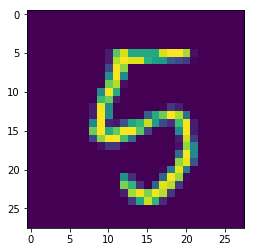

Label for that image :
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
5
(1, 784)


In [20]:
batch_xs, batch_ys = mnist.test.next_batch(1)
gen_image(batch_xs[0]).show()
print('Label for that image :')
print(batch_ys[0])
print(np.argmax(batch_ys))
print(batch_xs.shape)

In [21]:
# Convert images into 28x28 (they are downloaded as 1x784)
train_xdata = np.array([np.reshape(x, (28,28)) for x in mnist.train.images])
test_xdata = np.array([np.reshape(x, (28,28)) for x in mnist.test.images])

# Convert labels into one-hot encoded vectors
train_labels = np.argmax(mnist.train.labels, axis=1)
test_labels = np.argmax(mnist.test.labels, axis=1)


In [23]:
np.max(mnist.train.images)

1.0

** Step 1 : The model parameters.  We want a low learning rate and a small batch_size. **

In [26]:
## Set model parameters

batch_size = 100
learning_rate = 0.01
evaluation_size = 500

image_width = train_xdata[0].shape[0]
image_height = train_xdata[0].shape[1]
target_size = np.max(train_labels) + 1 # Also number of dimensions in Output Layer
num_channels = 1 # greyscale = 1 channel
epochs = 100 # number of epochs
eval_every = 5 # evaluate every % epochs


conv1_features = 25 # Output dimension for first convolutional layer OR number of feature detectors (number of neurons in a layer)
max_pool_size1 = 2 # NxN window for 1st max pool layer
fully_connected_size1 = 100 # Number of neurons of the First Dense Layer

conv2_features = 50 # Output dimension for second convolutional layer
max_pool_size2 = 2 # NxN window for 2nd max pool layer


**Step 2 : Create the Tensor variables, according to their dimensions.**

In [27]:
## Training Tensors
x_input_shape = (batch_size, image_width, image_height, num_channels)
x_input = tf.placeholder(tf.float32, shape=x_input_shape)
y_target = tf.placeholder(tf.int32, shape=(batch_size))

print(x_input)
print(y_target)

## Validation Tensors
eval_input_shape = (evaluation_size, image_width, image_height, num_channels)
eval_input = tf.placeholder(tf.float32, shape=eval_input_shape)
eval_target = tf.placeholder(tf.int32, shape=(evaluation_size))

print()
print(eval_input)
print(eval_target)

Tensor("Placeholder:0", shape=(100, 28, 28, 1), dtype=float32)
Tensor("Placeholder_1:0", shape=(100,), dtype=int32)

Tensor("Placeholder_2:0", shape=(500, 28, 28, 1), dtype=float32)
Tensor("Placeholder_3:0", shape=(500,), dtype=int32)


In [29]:
##############
### Convolutional layer variables
##############

## First Convolutional Layer
conv1_weight = tf.Variable(tf.truncated_normal([4, 4, num_channels, conv1_features],
                                               stddev=0.1, dtype=tf.float32))
conv1_bias = tf.Variable(tf.zeros([conv1_features], dtype=tf.float32))
print("conv1_weight Tensor :")
print(conv1_weight)
print()
print("conv1_bias Tensor :")
print(conv1_bias)
print()

## Second Convolutional Layer
conv2_weight = tf.Variable(tf.truncated_normal([4, 4, conv1_features, conv2_features],
                                               stddev=0.1, dtype=tf.float32))
conv2_bias = tf.Variable(tf.zeros([conv2_features], dtype=tf.float32))
print("conv2_weight Tensor :")
print(conv2_weight)
print()
print("conv2_bias Tensor :")
print(conv2_bias)
print()

conv1_weight Tensor :
<tf.Variable 'Variable_4:0' shape=(4, 4, 1, 25) dtype=float32_ref>

conv1_bias Tensor :
<tf.Variable 'Variable_5:0' shape=(25,) dtype=float32_ref>

conv2_weight Tensor :
<tf.Variable 'Variable_6:0' shape=(4, 4, 25, 50) dtype=float32_ref>

conv2_bias Tensor :
<tf.Variable 'Variable_7:0' shape=(50,) dtype=float32_ref>



In [30]:
##############
### Fully connected variables
##############



resulting_width = image_width // (max_pool_size1 * max_pool_size2)
resulting_height = image_height // (max_pool_size1 * max_pool_size2)



## First Dense Layer

# Here, we want to flatten the output data from the last convolutional layer.
full1_input_size = resulting_width * resulting_height * conv2_features

full1_weight = tf.Variable(tf.truncated_normal([full1_input_size, fully_connected_size1],
                          stddev=0.1, dtype=tf.float32))
full1_bias = tf.Variable(tf.truncated_normal([fully_connected_size1], stddev=0.1, dtype=tf.float32))
print("full1_weight Tensor :")
print(full1_weight)
print()
print("full1_bias Tensor :")
print(full1_bias)
print()





## Second Dense Layer

full2_weight = tf.Variable(tf.truncated_normal([fully_connected_size1, target_size],
                                               stddev=0.1, dtype=tf.float32))
full2_bias = tf.Variable(tf.truncated_normal([target_size], stddev=0.1, dtype=tf.float32))
print("full2_weight Tensor :")
print(full2_weight)
print()
print("full2_bias Tensor :")
print(full2_bias)
print()

full1_weight Tensor :
<tf.Variable 'Variable_8:0' shape=(2450, 100) dtype=float32_ref>

full1_bias Tensor :
<tf.Variable 'Variable_9:0' shape=(100,) dtype=float32_ref>

full2_weight Tensor :
<tf.Variable 'Variable_10:0' shape=(100, 10) dtype=float32_ref>

full2_bias Tensor :
<tf.Variable 'Variable_11:0' shape=(10,) dtype=float32_ref>



** Step 3 : The model operations. Operations : **
* Conv2D - ReLU - MaxPooling2D
* Conv2D - ReLU - MaxPooling2D
* Flattening
* Dense Layer, ReLU Activation
* Dense Layer, Softmax Activation


In [31]:
##############
### Initialize Model Operations
##############


def my_conv_net(input_data):
    # First Conv-ReLU-MaxPool Layer
    conv1 = tf.nn.conv2d(input_data, conv1_weight, strides=[1, 1, 1, 1], padding='SAME')
    relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_bias))
    max_pool1 = tf.nn.max_pool(relu1, ksize=[1, max_pool_size1, max_pool_size1, 1],
                               strides=[1, max_pool_size1, max_pool_size1, 1], padding='SAME')
    print(max_pool1)
    print

    # Second Conv-ReLU-MaxPool Layer
    conv2 = tf.nn.conv2d(max_pool1, conv2_weight, strides=[1, 1, 1, 1], padding='SAME')
    relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_bias))
    max_pool2 = tf.nn.max_pool(relu2, ksize=[1, max_pool_size2, max_pool_size2, 1],
                               strides=[1, max_pool_size2, max_pool_size2, 1], padding='SAME')
    print(max_pool2)
    print

    # Transform Output into a 1xN layer for next fully connected layer
    final_conv_shape = max_pool2.get_shape().as_list()
    final_shape = final_conv_shape[1] * final_conv_shape[2] * final_conv_shape[3]
    flat_output = tf.reshape(max_pool2, [final_conv_shape[0], final_shape])
    print(flat_output)
    print

    # First Fully Connected Layer
    fully_connected1 = tf.nn.relu(tf.add(tf.matmul(flat_output, full1_weight), full1_bias))
    print(fully_connected1)
    print

    # Second Fully Connected Layer
    final_model_output = tf.add(tf.matmul(fully_connected1, full2_weight), full2_bias)
    print(final_model_output)
    print
    
    return(final_model_output)


In [32]:
model_output = my_conv_net(x_input)
test_model_output = my_conv_net(eval_input)

# Declare Loss Function (softmax cross entropy)
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model_output, labels=y_target))

# Create a prediction function
prediction = tf.nn.softmax(model_output)
test_prediction = tf.nn.softmax(test_model_output)

# Create accuracy function
def get_accuracy(logits, targets):
    batch_predictions = np.argmax(logits, axis=1)
    num_correct = np.sum(np.equal(batch_predictions, targets))
    return(num_correct/batch_predictions.shape[0])

Tensor("MaxPool:0", shape=(100, 14, 14, 25), dtype=float32)
Tensor("MaxPool_1:0", shape=(100, 7, 7, 50), dtype=float32)
Tensor("Reshape:0", shape=(100, 2450), dtype=float32)
Tensor("Relu_2:0", shape=(100, 100), dtype=float32)
Tensor("Add_1:0", shape=(100, 10), dtype=float32)
Tensor("MaxPool_2:0", shape=(500, 14, 14, 25), dtype=float32)
Tensor("MaxPool_3:0", shape=(500, 7, 7, 50), dtype=float32)
Tensor("Reshape_1:0", shape=(500, 2450), dtype=float32)
Tensor("Relu_5:0", shape=(500, 100), dtype=float32)
Tensor("Add_3:0", shape=(500, 10), dtype=float32)


In [33]:
# Create an optimizer
my_optimizer = tf.train.AdamOptimizer(learning_rate, 0.5)
train_step = my_optimizer.minimize(loss)


In [34]:
## Initialize Variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    writer = tf.summary.FileWriter('./summaries/MNIST', sess.graph)

    ## Start training loop
    train_loss = []
    train_acc = []
    test_acc = []
    for i in range(epochs):
        # Batch creation
        rand_index = np.random.choice(len(train_xdata), size=batch_size)
        rand_x = train_xdata[rand_index]
        rand_x = np.expand_dims(rand_x, 3)
        rand_y = train_labels[rand_index]
        train_dict = {x_input: rand_x, y_target: rand_y}

        # Loss and Prediction Generation
        sess.run(train_step, feed_dict=train_dict)
        temp_train_loss, temp_train_preds = sess.run([loss, prediction], feed_dict=train_dict)
        temp_train_acc = get_accuracy(temp_train_preds, rand_y)

        if (i+1) % eval_every == 0:
            eval_index = np.random.choice(len(test_xdata), size=evaluation_size)
            eval_x = test_xdata[eval_index]
            eval_x = np.expand_dims(eval_x, 3)
            eval_y = test_labels[eval_index]
            test_dict = {eval_input: eval_x, eval_target: eval_y}
            test_preds = sess.run(test_prediction, feed_dict=test_dict)
            temp_test_acc = get_accuracy(test_preds, eval_y)

            # Record and print results
            train_loss.append(temp_train_loss)
            train_acc.append(temp_train_acc)
            test_acc.append(temp_test_acc)
            acc_and_loss = [(i+1), temp_train_loss, temp_train_acc, temp_test_acc]
            acc_and_loss = [np.round(x,4) for x in acc_and_loss]
            print('Generation # {}. Train Loss: {:.2f}. Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))
        
    eval_index = np.random.choice(len(test_xdata), size=evaluation_size)
    XVal = test_xdata[eval_index]
    XVal = np.expand_dims(XVal, 3)
    YVal = test_labels[eval_index]
    test_dict = {eval_input: XVal, eval_target: YVal}
    test_preds = sess.run(test_prediction, feed_dict=test_dict)
    
sess.close()

Generation # 5. Train Loss: 1.22. Train Acc (Test Acc): 0.58 (0.48)


Generation # 10. Train Loss: 0.64. Train Acc (Test Acc): 0.80 (0.72)


Generation # 15. Train Loss: 0.52. Train Acc (Test Acc): 0.85 (0.85)


Generation # 20. Train Loss: 0.18. Train Acc (Test Acc): 0.94 (0.91)


Generation # 25. Train Loss: 0.20. Train Acc (Test Acc): 0.95 (0.91)


Generation # 30. Train Loss: 0.08. Train Acc (Test Acc): 0.98 (0.94)


Generation # 35. Train Loss: 0.06. Train Acc (Test Acc): 1.00 (0.97)


Generation # 40. Train Loss: 0.05. Train Acc (Test Acc): 1.00 (0.95)


Generation # 45. Train Loss: 0.05. Train Acc (Test Acc): 1.00 (0.95)


Generation # 50. Train Loss: 0.12. Train Acc (Test Acc): 0.96 (0.95)


Generation # 55. Train Loss: 0.05. Train Acc (Test Acc): 0.99 (0.95)


Generation # 60. Train Loss: 0.05. Train Acc (Test Acc): 0.99 (0.98)


Generation # 65. Train Loss: 0.03. Train Acc (Test Acc): 0.99 (0.97)


Generation # 70. Train Loss: 0.02. Train Acc (Test Acc): 1.00 (0.95)


Generation # 75. Train Loss: 0.07. Train Acc (Test Acc): 0.97 (0.93)


Generation # 80. Train Loss: 0.06. Train Acc (Test Acc): 0.99 (0.92)


Generation # 85. Train Loss: 0.06. Train Acc (Test Acc): 0.99 (0.96)


Generation # 90. Train Loss: 0.06. Train Acc (Test Acc): 0.97 (0.96)


Generation # 95. Train Loss: 0.03. Train Acc (Test Acc): 1.00 (0.97)


Generation # 100. Train Loss: 0.06. Train Acc (Test Acc): 0.99 (0.96)


Let's see some results on 10 evaluation images :

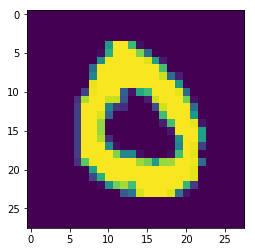

Class for that image :
0
Prediction for that image :
0


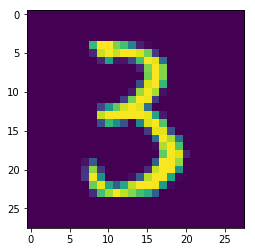

Class for that image :
3
Prediction for that image :
3


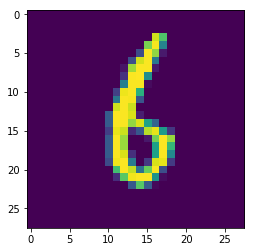

Class for that image :
6
Prediction for that image :
6


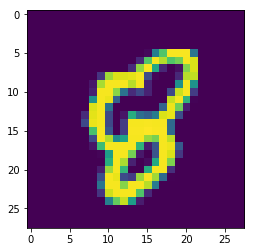

Class for that image :
8
Prediction for that image :
8


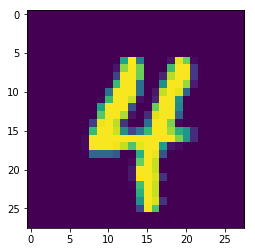

Class for that image :
4
Prediction for that image :
4


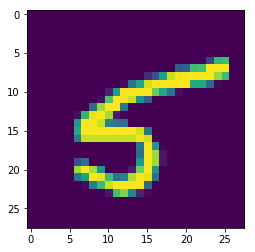

Class for that image :
5
Prediction for that image :
5


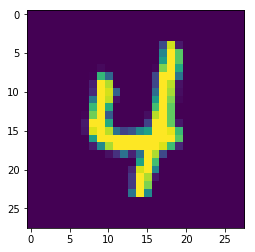

Class for that image :
4
Prediction for that image :
4


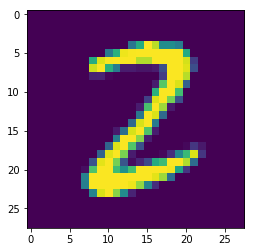

Class for that image :
2
Prediction for that image :
2


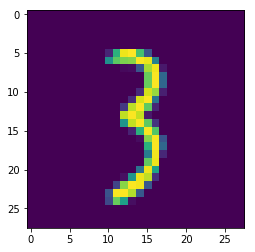

Class for that image :
3
Prediction for that image :
3


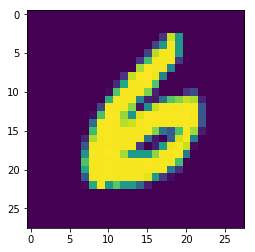

Class for that image :
6
Prediction for that image :
6


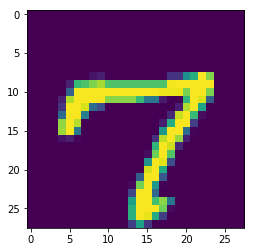

Class for that image :
7
Prediction for that image :
7


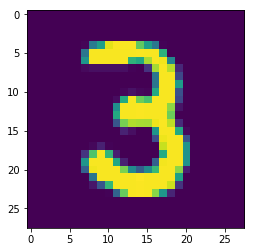

Class for that image :
3
Prediction for that image :
3


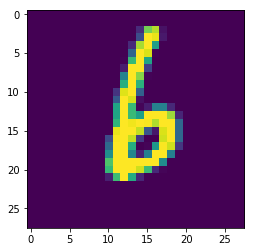

Class for that image :
6
Prediction for that image :
6


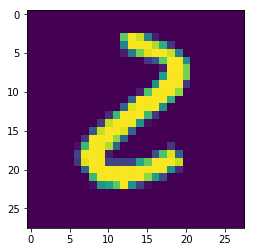

Class for that image :
2
Prediction for that image :
8


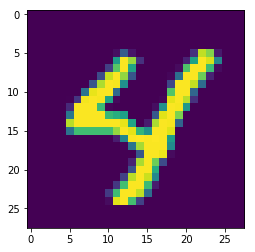

Class for that image :
4
Prediction for that image :
4


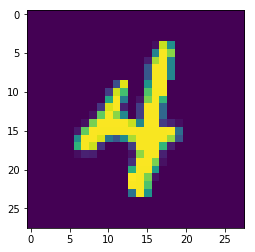

Class for that image :
4
Prediction for that image :
4


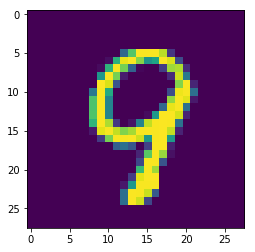

Class for that image :
9
Prediction for that image :
9


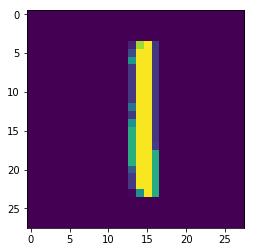

Class for that image :
1
Prediction for that image :
1


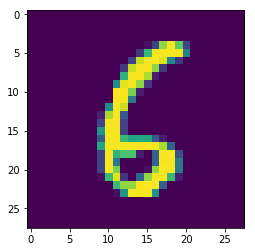

Class for that image :
6
Prediction for that image :
6


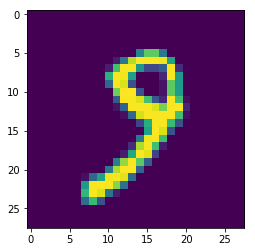

Class for that image :
9
Prediction for that image :
9


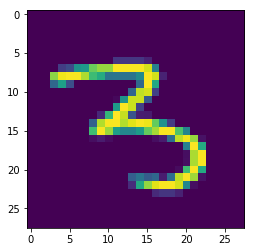

Class for that image :
3
Prediction for that image :
3


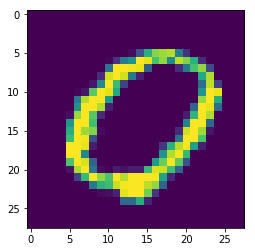

Class for that image :
0
Prediction for that image :
0


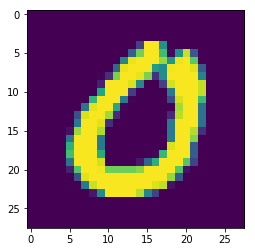

Class for that image :
0
Prediction for that image :
0


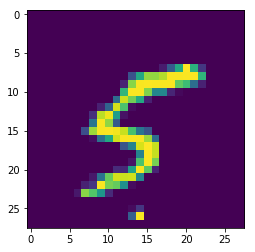

Class for that image :
5
Prediction for that image :
5


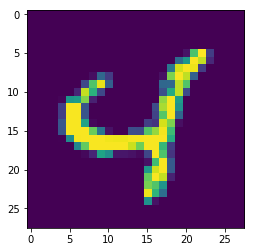

Class for that image :
4
Prediction for that image :
4


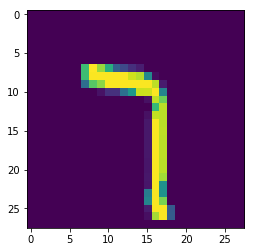

Class for that image :
7
Prediction for that image :
7


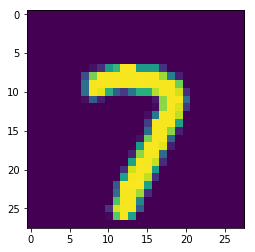

Class for that image :
7
Prediction for that image :
7


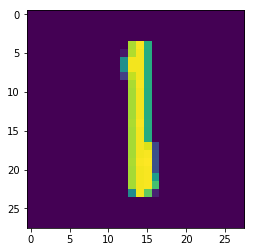

Class for that image :
1
Prediction for that image :
1


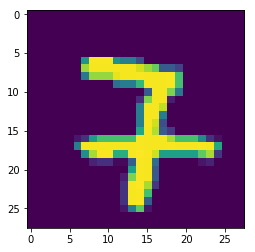

Class for that image :
7
Prediction for that image :
7


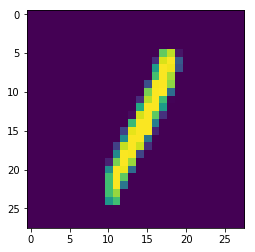

Class for that image :
1
Prediction for that image :
1


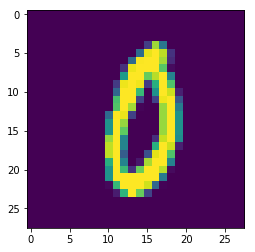

Class for that image :
0
Prediction for that image :
0


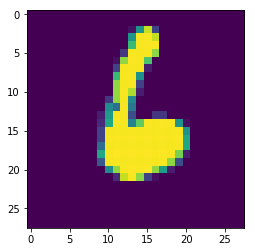

Class for that image :
6
Prediction for that image :
6


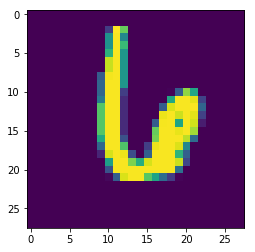

Class for that image :
6
Prediction for that image :
6


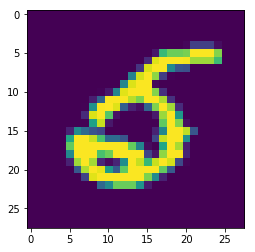

Class for that image :
5
Prediction for that image :
5


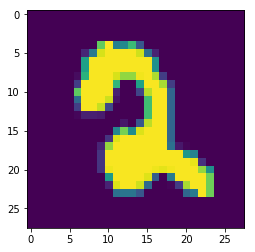

Class for that image :
2
Prediction for that image :
2


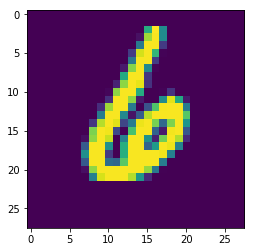

Class for that image :
6
Prediction for that image :
6


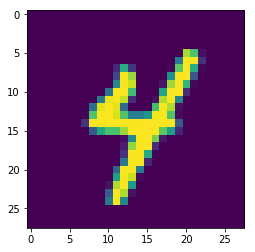

Class for that image :
4
Prediction for that image :
4


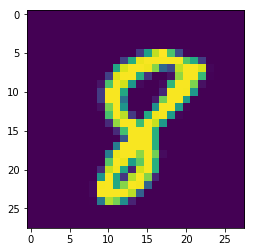

Class for that image :
8
Prediction for that image :
8


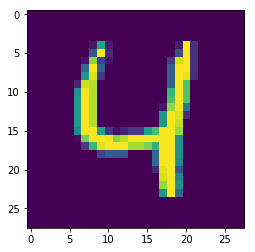

Class for that image :
4
Prediction for that image :
4


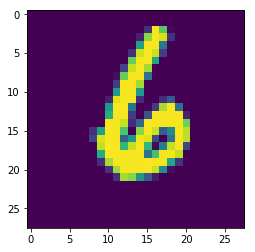

Class for that image :
6
Prediction for that image :
6


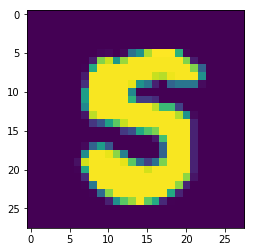

Class for that image :
5
Prediction for that image :
5


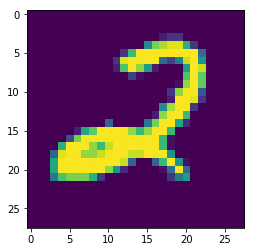

Class for that image :
2
Prediction for that image :
2


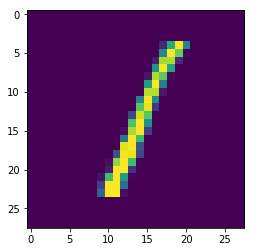

Class for that image :
1
Prediction for that image :
1


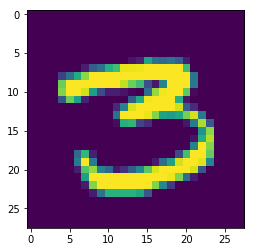

Class for that image :
3
Prediction for that image :
3


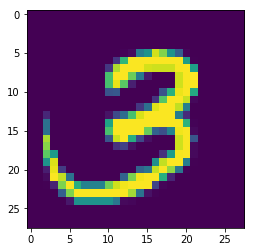

Class for that image :
3
Prediction for that image :
3


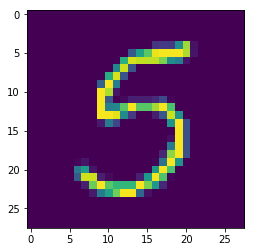

Class for that image :
5
Prediction for that image :
5


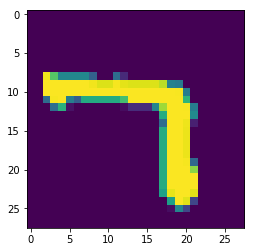

Class for that image :
7
Prediction for that image :
7


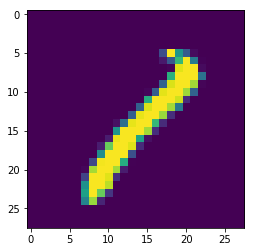

Class for that image :
1
Prediction for that image :
1


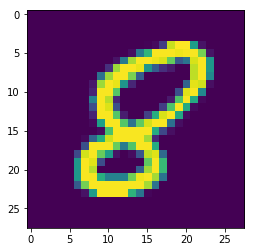

Class for that image :
8
Prediction for that image :
8


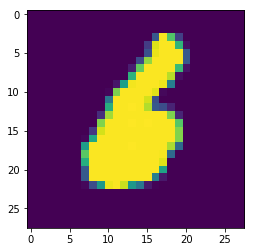

Class for that image :
6
Prediction for that image :
6


In [35]:
for ii in range(50):
    img = XVal[ii].copy()
    img = np.reshape(img,(img.shape[0],img.shape[1]))
    gen_image(img).show()
    print('Class for that image :')
    print(YVal[ii])
    print
    print('Prediction for that image :')
    print(np.argmax(test_preds[ii]))

--------------------------

## 2. KERAS Implementation of CNN on MNIST dataset

**We have just seen how complex a Convolutional Neural Network can be using the TensorFlow framework. Can we do this using KERAS?**

In [36]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.


For packages concern, we want the backend of our KERAS network to use Tensorflow.

In [37]:
import os
import imp
from tensorflow.examples.tutorials.mnist import input_data

def set_keras_backend(backend):
    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        imp.reload(K)
        assert K.backend() == backend

In [38]:
set_keras_backend("tensorflow")

We re-read the MNIST dataset.

In [40]:
mnist = input_data.read_data_sets(pathData, one_hot=True)

# Convert images into 28x28 (they are downloaded as 1x784)
train_xdata = np.array([np.reshape(x, (28,28))*255 for x in mnist.train.images])
#train_xdata = train_xdata[:10000,:]
test_xdata = np.array([np.reshape(x, (28,28))*255 for x in mnist.test.images])
#test_xdata = test_xdata[:10000,:]

Extracting dataMNIST\train-images-idx3-ubyte.gz


Extracting dataMNIST\train-labels-idx1-ubyte.gz
Extracting dataMNIST\t10k-images-idx3-ubyte.gz
Extracting dataMNIST\t10k-labels-idx1-ubyte.gz


In [41]:
# Convert labels into one-hot encoded vectors
train_labels = mnist.train.labels
test_labels = mnist.test.labels

#train_labels = train_labels[:10000]
#test_labels = test_labels[:10000]

In [42]:
print(train_xdata.shape)
print(test_xdata.shape)


In [44]:
print(train_labels.shape)
print(test_labels.shape)

Let's redefine the parameters :

In [44]:
## Model parameters

batch_size = 100
num_classes = 10
epochs = 12

conv1_features = 25 # Output dimension for first convolutional layer
max_pool_size1 = 2 # NxN window for 1st max pool layer
fully_connected_size1 = 100 # Number of neurons of the First Dense Layer

conv2_features = 50 # Output dimension for second convolutional layer
max_pool_size2 = 2 # NxN window for 2nd max pool layer

Depending on the version of Tensorflow, the shape of the input data must be built :

In [46]:
## Get the right shape of the data. The images are of dimension (28,28)

# input image dimensions
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    x_train = train_xdata.reshape(train_xdata.shape[0], 1, img_rows, img_cols)
    x_test = test_xdata.reshape(test_xdata.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = train_xdata.reshape(train_xdata.shape[0], img_rows, img_cols, 1)
    x_test = test_xdata.reshape(test_xdata.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    

And we want to normalize our matrix.

In [47]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = train_labels.copy()
y_test = test_labels.copy()

x_train shape: (55000, 28, 28, 1)
55000 train samples
10000 test samples


**We can now build the KERAS model, using the same parameters as before.**

**Exercice : Complete the cell below to implement a KERAS model similar to the one in Tensorflow.**

We will ignore the zero_padding and the strides options here.

In [ ]:
## Model construction

model = Sequential()

## Concolutional Layer 1
model.add(Conv2D(conv1_features, kernel_size=(4, 4), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(max_pool_size1, max_pool_size1)))

## Convolutional Layer 2
############ ENTER YOUR CODE HERE #############
model.add(Conv2D(conv2_features, kernel_size=(2, 2), activation="relu"))
model.add(MaxPooling2D(pool_size=(max_pool_size2, max_pool_size2)))
############ END OF THE CODE #############
model.add(Flatten())

## Classification block (Fully Connected Layers)
model.add(Dense(fully_connected_size1, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])


**Execution : **

In [ ]:

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 55000 samples, validate on 10000 samples
Epoch 1/12


  100/55000 [..............................] - ETA: 316s - loss: 2.2888 - acc: 0.1700

  200/55000 [..............................] - ETA: 176s - loss: 2.5682 - acc: 0.1450

  300/55000 [..............................] - ETA: 127s - loss: 2.4371 - acc: 0.1233

  400/55000 [..............................] - ETA: 104s - loss: 2.3637 - acc: 0.1900

  500/55000 [..............................] - ETA: 89s - loss: 2.3250 - acc: 0.2180 

  600/55000 [..............................] - ETA: 79s - loss: 2.2897 - acc: 0.2433

  700/55000 [..............................] - ETA: 73s - loss: 2.2353 - acc: 0.2800

  800/55000 [..............................] - ETA: 68s - loss: 2.1760 - acc: 0.3175

  900/55000 [..............................] - ETA: 64s - loss: 2.1181 - acc: 0.3378

 1000/55000 [..............................] - ETA: 61s - loss: 2.0372 - acc: 0.3650

 1100/55000 [..............................] - ETA: 58s - loss: 1.9557 - acc: 0.3845

 1200/55000 [..............................] - ETA: 56s - loss: 1.8634 - acc: 0.4117

 1300/55000 [..............................] - ETA: 54s - loss: 1.7909 - acc: 0.4300

 1400/55000 [..............................] - ETA: 52s - loss: 1.7142 - acc: 0.4536

 1500/55000 [..............................] - ETA: 51s - loss: 1.6526 - acc: 0.4747

 1600/55000 [..............................] - ETA: 49s - loss: 1.5841 - acc: 0.4962

 1700/55000 [..............................] - ETA: 49s - loss: 1.5289 - acc: 0.5147

 1800/55000 [..............................] - ETA: 48s - loss: 1.4709 - acc: 0.5333

 1900/55000 [>.............................] - ETA: 47s - loss: 1.4198 - acc: 0.5500

 2000/55000 [>.............................] - ETA: 46s - loss: 1.3796 - acc: 0.5650

 2100/55000 [>.............................] - ETA: 45s - loss: 1.3368 - acc: 0.5781

 2200/55000 [>.............................] - ETA: 44s - loss: 1.2977 - acc: 0.5891

 2300/55000 [>.............................] - ETA: 43s - loss: 1.2574 - acc: 0.6009

 2400/55000 [>.............................] - ETA: 43s - loss: 1.2232 - acc: 0.6108

 2500/55000 [>.............................] - ETA: 42s - loss: 1.1909 - acc: 0.6208

 2600/55000 [>.............................] - ETA: 42s - loss: 1.1573 - acc: 0.6315

 2700/55000 [>.............................] - ETA: 41s - loss: 1.1270 - acc: 0.6411

 2800/55000 [>.............................] - ETA: 41s - loss: 1.0960 - acc: 0.6511

 2900/55000 [>.............................] - ETA: 41s - loss: 1.0723 - acc: 0.6583

 3000/55000 [>.............................] - ETA: 40s - loss: 1.0457 - acc: 0.6680

 3100/55000 [>.............................] - ETA: 40s - loss: 1.0172 - acc: 0.6768

 3200/55000 [>.............................] - ETA: 39s - loss: 0.9929 - acc: 0.6847

 3300/55000 [>.............................] - ETA: 39s - loss: 0.9677 - acc: 0.6921

 3400/55000 [>.............................] - ETA: 39s - loss: 0.9504 - acc: 0.6991

 3500/55000 [>.............................] - ETA: 38s - loss: 0.9321 - acc: 0.7054

 3600/55000 [>.............................] - ETA: 38s - loss: 0.9186 - acc: 0.7106

 3700/55000 [=>............................] - ETA: 38s - loss: 0.9035 - acc: 0.7157

 3800/55000 [=>............................] - ETA: 38s - loss: 0.8863 - acc: 0.7216

 3900/55000 [=>............................] - ETA: 37s - loss: 0.8670 - acc: 0.7272

 4000/55000 [=>............................] - ETA: 37s - loss: 0.8534 - acc: 0.7315

 4100/55000 [=>............................] - ETA: 37s - loss: 0.8358 - acc: 0.7373

 4200/55000 [=>............................] - ETA: 37s - loss: 0.8210 - acc: 0.7421

 4300/55000 [=>............................] - ETA: 36s - loss: 0.8081 - acc: 0.7470

 4400/55000 [=>............................] - ETA: 36s - loss: 0.7928 - acc: 0.7518

 4500/55000 [=>............................] - ETA: 36s - loss: 0.7780 - acc: 0.7560

 4600/55000 [=>............................] - ETA: 36s - loss: 0.7638 - acc: 0.7602

 4700/55000 [=>............................] - ETA: 36s - loss: 0.7526 - acc: 0.7643

 4800/55000 [=>............................] - ETA: 35s - loss: 0.7394 - acc: 0.7681

 4900/55000 [=>............................] - ETA: 35s - loss: 0.7277 - acc: 0.7722

 5000/55000 [=>............................] - ETA: 35s - loss: 0.7175 - acc: 0.7758

 5100/55000 [=>............................] - ETA: 35s - loss: 0.7099 - acc: 0.7778

 5200/55000 [=>............................] - ETA: 35s - loss: 0.7009 - acc: 0.7812

 5300/55000 [=>............................] - ETA: 34s - loss: 0.6912 - acc: 0.7843

 5400/55000 [=>............................] - ETA: 34s - loss: 0.6824 - acc: 0.7869

 5500/55000 [==>...........................] - ETA: 34s - loss: 0.6723 - acc: 0.7900

 5600/55000 [==>...........................] - ETA: 34s - loss: 0.6626 - acc: 0.7925

 5700/55000 [==>...........................] - ETA: 34s - loss: 0.6524 - acc: 0.7956

 5800/55000 [==>...........................] - ETA: 34s - loss: 0.6455 - acc: 0.7974

 5900/55000 [==>...........................] - ETA: 34s - loss: 0.6376 - acc: 0.7997

 6000/55000 [==>...........................] - ETA: 33s - loss: 0.6309 - acc: 0.8018

 6100/55000 [==>...........................] - ETA: 33s - loss: 0.6231 - acc: 0.8043

 6200/55000 [==>...........................] - ETA: 33s - loss: 0.6181 - acc: 0.8061

 6300/55000 [==>...........................] - ETA: 33s - loss: 0.6109 - acc: 0.8083

 6400/55000 [==>...........................] - ETA: 33s - loss: 0.6033 - acc: 0.8106

 6500/55000 [==>...........................] - ETA: 33s - loss: 0.5984 - acc: 0.8122

 6600/55000 [==>...........................] - ETA: 33s - loss: 0.5918 - acc: 0.8141

 6700/55000 [==>...........................] - ETA: 33s - loss: 0.5863 - acc: 0.8157

 6800/55000 [==>...........................] - ETA: 32s - loss: 0.5789 - acc: 0.8179

 6900/55000 [==>...........................] - ETA: 32s - loss: 0.5716 - acc: 0.8203

 7000/55000 [==>...........................] - ETA: 32s - loss: 0.5660 - acc: 0.8221

 7100/55000 [==>...........................] - ETA: 32s - loss: 0.5605 - acc: 0.8238

 7200/55000 [==>...........................] - ETA: 32s - loss: 0.5553 - acc: 0.8258

 7300/55000 [==>...........................] - ETA: 32s - loss: 0.5485 - acc: 0.8281

 7400/55000 [===>..........................] - ETA: 32s - loss: 0.5432 - acc: 0.8297

 7500/55000 [===>..........................] - ETA: 32s - loss: 0.5374 - acc: 0.8315

 7600/55000 [===>..........................] - ETA: 32s - loss: 0.5316 - acc: 0.8333

 7700/55000 [===>..........................] - ETA: 31s - loss: 0.5263 - acc: 0.8349

 7800/55000 [===>..........................] - ETA: 31s - loss: 0.5208 - acc: 0.8367

 7900/55000 [===>..........................] - ETA: 31s - loss: 0.5146 - acc: 0.8386

 8000/55000 [===>..........................] - ETA: 31s - loss: 0.5094 - acc: 0.8401

 8100/55000 [===>..........................] - ETA: 31s - loss: 0.5037 - acc: 0.8420

 8200/55000 [===>..........................] - ETA: 31s - loss: 0.4988 - acc: 0.8434

 8300/55000 [===>..........................] - ETA: 31s - loss: 0.4936 - acc: 0.8451

 8400/55000 [===>..........................] - ETA: 31s - loss: 0.4883 - acc: 0.8468

 8500/55000 [===>..........................] - ETA: 31s - loss: 0.4829 - acc: 0.8485

 8600/55000 [===>..........................] - ETA: 31s - loss: 0.4795 - acc: 0.8495

 8700/55000 [===>..........................] - ETA: 30s - loss: 0.4763 - acc: 0.8509

 8800/55000 [===>..........................] - ETA: 30s - loss: 0.4735 - acc: 0.8520

 8900/55000 [===>..........................] - ETA: 30s - loss: 0.4699 - acc: 0.8533

 9000/55000 [===>..........................] - ETA: 30s - loss: 0.4662 - acc: 0.8546

 9100/55000 [===>..........................] - ETA: 30s - loss: 0.4620 - acc: 0.8559

 9200/55000 [====>.........................] - ETA: 30s - loss: 0.4594 - acc: 0.8566

 9300/55000 [====>.........................] - ETA: 30s - loss: 0.4560 - acc: 0.8577

 9400/55000 [====>.........................] - ETA: 30s - loss: 0.4544 - acc: 0.8586

 9500/55000 [====>.........................] - ETA: 30s - loss: 0.4511 - acc: 0.8597

 9600/55000 [====>.........................] - ETA: 30s - loss: 0.4472 - acc: 0.8606

 9700/55000 [====>.........................] - ETA: 29s - loss: 0.4436 - acc: 0.8618

 9800/55000 [====>.........................] - ETA: 29s - loss: 0.4404 - acc: 0.8629

 9900/55000 [====>.........................] - ETA: 29s - loss: 0.4383 - acc: 0.8636

10000/55000 [====>.........................] - ETA: 29s - loss: 0.4355 - acc: 0.8645

10100/55000 [====>.........................] - ETA: 29s - loss: 0.4334 - acc: 0.8650

10200/55000 [====>.........................] - ETA: 29s - loss: 0.4315 - acc: 0.8658

10300/55000 [====>.........................] - ETA: 29s - loss: 0.4284 - acc: 0.8667

10400/55000 [====>.........................] - ETA: 29s - loss: 0.4257 - acc: 0.8675

10500/55000 [====>.........................] - ETA: 29s - loss: 0.4239 - acc: 0.8683

10600/55000 [====>.........................] - ETA: 29s - loss: 0.4210 - acc: 0.8692

10700/55000 [====>.........................] - ETA: 28s - loss: 0.4184 - acc: 0.8702

10800/55000 [====>.........................] - ETA: 28s - loss: 0.4156 - acc: 0.8710

10900/55000 [====>.........................] - ETA: 28s - loss: 0.4127 - acc: 0.8719

11000/55000 [=====>........................] - ETA: 28s - loss: 0.4101 - acc: 0.8727

11100/55000 [=====>........................] - ETA: 28s - loss: 0.4079 - acc: 0.8736

11200/55000 [=====>........................] - ETA: 28s - loss: 0.4053 - acc: 0.8745

11300/55000 [=====>........................] - ETA: 28s - loss: 0.4030 - acc: 0.8752

11400/55000 [=====>........................] - ETA: 28s - loss: 0.4001 - acc: 0.8761

11500/55000 [=====>........................] - ETA: 28s - loss: 0.3985 - acc: 0.8766

11600/55000 [=====>........................] - ETA: 28s - loss: 0.3959 - acc: 0.8774

11700/55000 [=====>........................] - ETA: 28s - loss: 0.3934 - acc: 0.8783

11800/55000 [=====>........................] - ETA: 28s - loss: 0.3909 - acc: 0.8790

11900/55000 [=====>........................] - ETA: 27s - loss: 0.3888 - acc: 0.8796

12000/55000 [=====>........................] - ETA: 27s - loss: 0.3866 - acc: 0.8803

12100/55000 [=====>........................] - ETA: 27s - loss: 0.3844 - acc: 0.8809

12200/55000 [=====>........................] - ETA: 27s - loss: 0.3828 - acc: 0.8816

12300/55000 [=====>........................] - ETA: 27s - loss: 0.3810 - acc: 0.8823

12400/55000 [=====>........................] - ETA: 27s - loss: 0.3797 - acc: 0.8827

12500/55000 [=====>........................] - ETA: 27s - loss: 0.3781 - acc: 0.8834

12600/55000 [=====>........................] - ETA: 27s - loss: 0.3761 - acc: 0.8840

12700/55000 [=====>........................] - ETA: 27s - loss: 0.3736 - acc: 0.8848

12800/55000 [=====>........................] - ETA: 27s - loss: 0.3719 - acc: 0.8854

12900/55000 [======>.......................] - ETA: 27s - loss: 0.3699 - acc: 0.8860

13000/55000 [======>.......................] - ETA: 26s - loss: 0.3675 - acc: 0.8865

13100/55000 [======>.......................] - ETA: 26s - loss: 0.3652 - acc: 0.8873

13200/55000 [======>.......................] - ETA: 26s - loss: 0.3629 - acc: 0.8880

13300/55000 [======>.......................] - ETA: 26s - loss: 0.3611 - acc: 0.8886

13400/55000 [======>.......................] - ETA: 26s - loss: 0.3603 - acc: 0.8890

13500/55000 [======>.......................] - ETA: 26s - loss: 0.3592 - acc: 0.8894

13600/55000 [======>.......................] - ETA: 26s - loss: 0.3576 - acc: 0.8899

13700/55000 [======>.......................] - ETA: 26s - loss: 0.3559 - acc: 0.8904

13800/55000 [======>.......................] - ETA: 26s - loss: 0.3543 - acc: 0.8908

13900/55000 [======>.......................] - ETA: 26s - loss: 0.3526 - acc: 0.8913

14000/55000 [======>.......................] - ETA: 26s - loss: 0.3507 - acc: 0.8916

14100/55000 [======>.......................] - ETA: 26s - loss: 0.3488 - acc: 0.8923

14200/55000 [======>.......................] - ETA: 26s - loss: 0.3480 - acc: 0.8924

14300/55000 [======>.......................] - ETA: 26s - loss: 0.3466 - acc: 0.8927

14400/55000 [======>.......................] - ETA: 26s - loss: 0.3446 - acc: 0.8934

14500/55000 [======>.......................] - ETA: 26s - loss: 0.3428 - acc: 0.8939

14600/55000 [======>.......................] - ETA: 26s - loss: 0.3408 - acc: 0.8945

14700/55000 [=======>......................] - ETA: 26s - loss: 0.3392 - acc: 0.8950

14800/55000 [=======>......................] - ETA: 26s - loss: 0.3379 - acc: 0.8954

14900/55000 [=======>......................] - ETA: 25s - loss: 0.3361 - acc: 0.8959

15000/55000 [=======>......................] - ETA: 25s - loss: 0.3344 - acc: 0.8965

15100/55000 [=======>......................] - ETA: 25s - loss: 0.3332 - acc: 0.8970

15200/55000 [=======>......................] - ETA: 25s - loss: 0.3316 - acc: 0.8974

15300/55000 [=======>......................] - ETA: 25s - loss: 0.3302 - acc: 0.8978

15400/55000 [=======>......................] - ETA: 25s - loss: 0.3283 - acc: 0.8984

15500/55000 [=======>......................] - ETA: 25s - loss: 0.3278 - acc: 0.8987

15600/55000 [=======>......................] - ETA: 25s - loss: 0.3266 - acc: 0.8991

15700/55000 [=======>......................] - ETA: 25s - loss: 0.3260 - acc: 0.8994

15800/55000 [=======>......................] - ETA: 25s - loss: 0.3245 - acc: 0.8997

15900/55000 [=======>......................] - ETA: 25s - loss: 0.3230 - acc: 0.9003

16000/55000 [=======>......................] - ETA: 25s - loss: 0.3212 - acc: 0.9008

16100/55000 [=======>......................] - ETA: 25s - loss: 0.3201 - acc: 0.9012

16200/55000 [=======>......................] - ETA: 25s - loss: 0.3192 - acc: 0.9014

16300/55000 [=======>......................] - ETA: 24s - loss: 0.3180 - acc: 0.9017

16400/55000 [=======>......................] - ETA: 24s - loss: 0.3164 - acc: 0.9021

16500/55000 [========>.....................] - ETA: 24s - loss: 0.3147 - acc: 0.9027

16600/55000 [========>.....................] - ETA: 24s - loss: 0.3133 - acc: 0.9031

16700/55000 [========>.....................] - ETA: 24s - loss: 0.3122 - acc: 0.9036

16800/55000 [========>.....................] - ETA: 24s - loss: 0.3107 - acc: 0.9040

16900/55000 [========>.....................] - ETA: 24s - loss: 0.3093 - acc: 0.9045

17000/55000 [========>.....................] - ETA: 24s - loss: 0.3081 - acc: 0.9049

17100/55000 [========>.....................] - ETA: 24s - loss: 0.3066 - acc: 0.9053

17200/55000 [========>.....................] - ETA: 24s - loss: 0.3049 - acc: 0.9058

17300/55000 [========>.....................] - ETA: 24s - loss: 0.3034 - acc: 0.9062

17400/55000 [========>.....................] - ETA: 24s - loss: 0.3020 - acc: 0.9066

17500/55000 [========>.....................] - ETA: 24s - loss: 0.3007 - acc: 0.9070

17600/55000 [========>.....................] - ETA: 24s - loss: 0.2995 - acc: 0.9074

17700/55000 [========>.....................] - ETA: 23s - loss: 0.2982 - acc: 0.9077

17800/55000 [========>.....................] - ETA: 23s - loss: 0.2968 - acc: 0.9081

17900/55000 [========>.....................] - ETA: 23s - loss: 0.2956 - acc: 0.9084

18000/55000 [========>.....................] - ETA: 23s - loss: 0.2944 - acc: 0.9087

18100/55000 [========>.....................] - ETA: 23s - loss: 0.2940 - acc: 0.9090

18200/55000 [========>.....................] - ETA: 23s - loss: 0.2930 - acc: 0.9093

18300/55000 [========>.....................] - ETA: 23s - loss: 0.2916 - acc: 0.9098

18400/55000 [=========>....................] - ETA: 23s - loss: 0.2903 - acc: 0.9102

18500/55000 [=========>....................] - ETA: 23s - loss: 0.2893 - acc: 0.9105

18600/55000 [=========>....................] - ETA: 23s - loss: 0.2884 - acc: 0.9107

18700/55000 [=========>....................] - ETA: 23s - loss: 0.2873 - acc: 0.9111

18800/55000 [=========>....................] - ETA: 23s - loss: 0.2869 - acc: 0.9113

18900/55000 [=========>....................] - ETA: 23s - loss: 0.2857 - acc: 0.9117

19000/55000 [=========>....................] - ETA: 23s - loss: 0.2846 - acc: 0.9120

19100/55000 [=========>....................] - ETA: 23s - loss: 0.2835 - acc: 0.9123

19200/55000 [=========>....................] - ETA: 22s - loss: 0.2822 - acc: 0.9127

19300/55000 [=========>....................] - ETA: 22s - loss: 0.2812 - acc: 0.9130

19400/55000 [=========>....................] - ETA: 22s - loss: 0.2806 - acc: 0.9131



19500/55000 [=========>....................] - ETA: 22s - loss: 0.2795 - acc: 0.9135

19600/55000 [=========>....................] - ETA: 22s - loss: 0.2783 - acc: 0.9139

19700/55000 [=========>....................] - ETA: 22s - loss: 0.2778 - acc: 0.9141

19800/55000 [=========>....................] - ETA: 22s - loss: 0.2767 - acc: 0.9144

19900/55000 [=========>....................] - ETA: 22s - loss: 0.2758 - acc: 0.9147

20000/55000 [=========>....................] - ETA: 22s - loss: 0.2757 - acc: 0.9148

20100/55000 [=========>....................] - ETA: 22s - loss: 0.2754 - acc: 0.9151

20200/55000 [==========>...................] - ETA: 22s - loss: 0.2751 - acc: 0.9152

20300/55000 [==========>...................] - ETA: 22s - loss: 0.2738 - acc: 0.9156

20400/55000 [==========>...................] - ETA: 22s - loss: 0.2733 - acc: 0.9157

20500/55000 [==========>...................] - ETA: 22s - loss: 0.2727 - acc: 0.9159

20600/55000 [==========>...................] - ETA: 22s - loss: 0.2721 - acc: 0.9160

20700/55000 [==========>...................] - ETA: 21s - loss: 0.2711 - acc: 0.9163

20800/55000 [==========>...................] - ETA: 21s - loss: 0.2700 - acc: 0.9166

20900/55000 [==========>...................] - ETA: 21s - loss: 0.2690 - acc: 0.9169

21000/55000 [==========>...................] - ETA: 21s - loss: 0.2679 - acc: 0.9173

21100/55000 [==========>...................] - ETA: 21s - loss: 0.2671 - acc: 0.9175

21200/55000 [==========>...................] - ETA: 21s - loss: 0.2663 - acc: 0.9177

21300/55000 [==========>...................] - ETA: 21s - loss: 0.2654 - acc: 0.9179

21400/55000 [==========>...................] - ETA: 21s - loss: 0.2644 - acc: 0.9182

21500/55000 [==========>...................] - ETA: 21s - loss: 0.2638 - acc: 0.9184

21600/55000 [==========>...................] - ETA: 21s - loss: 0.2628 - acc: 0.9187

21700/55000 [==========>...................] - ETA: 21s - loss: 0.2623 - acc: 0.9188

21800/55000 [==========>...................] - ETA: 21s - loss: 0.2621 - acc: 0.9190

21900/55000 [==========>...................] - ETA: 21s - loss: 0.2614 - acc: 0.9192

22000/55000 [===========>..................] - ETA: 21s - loss: 0.2614 - acc: 0.9193

22100/55000 [===========>..................] - ETA: 21s - loss: 0.2607 - acc: 0.9195

22200/55000 [===========>..................] - ETA: 21s - loss: 0.2597 - acc: 0.9198

22300/55000 [===========>..................] - ETA: 20s - loss: 0.2591 - acc: 0.9200

22400/55000 [===========>..................] - ETA: 20s - loss: 0.2585 - acc: 0.9201

22500/55000 [===========>..................] - ETA: 20s - loss: 0.2575 - acc: 0.9204

22600/55000 [===========>..................] - ETA: 20s - loss: 0.2567 - acc: 0.9207

22700/55000 [===========>..................] - ETA: 20s - loss: 0.2559 - acc: 0.9209

22800/55000 [===========>..................] - ETA: 20s - loss: 0.2550 - acc: 0.9211

22900/55000 [===========>..................] - ETA: 20s - loss: 0.2541 - acc: 0.9214

23000/55000 [===========>..................] - ETA: 20s - loss: 0.2540 - acc: 0.9215

23100/55000 [===========>..................] - ETA: 20s - loss: 0.2533 - acc: 0.9217

23200/55000 [===========>..................] - ETA: 20s - loss: 0.2525 - acc: 0.9220

23300/55000 [===========>..................] - ETA: 20s - loss: 0.2518 - acc: 0.9222

23400/55000 [===========>..................] - ETA: 20s - loss: 0.2510 - acc: 0.9225

23500/55000 [===========>..................] - ETA: 20s - loss: 0.2501 - acc: 0.9228

23600/55000 [===========>..................] - ETA: 20s - loss: 0.2492 - acc: 0.9230

23700/55000 [===========>..................] - ETA: 20s - loss: 0.2486 - acc: 0.9232

23800/55000 [===========>..................] - ETA: 19s - loss: 0.2481 - acc: 0.9234

23900/55000 [============>.................] - ETA: 19s - loss: 0.2476 - acc: 0.9236

24000/55000 [============>.................] - ETA: 19s - loss: 0.2473 - acc: 0.9238

24100/55000 [============>.................] - ETA: 19s - loss: 0.2465 - acc: 0.9240

24200/55000 [============>.................] - ETA: 19s - loss: 0.2456 - acc: 0.9243

24300/55000 [============>.................] - ETA: 19s - loss: 0.2450 - acc: 0.9244

24400/55000 [============>.................] - ETA: 19s - loss: 0.2443 - acc: 0.9245

24500/55000 [============>.................] - ETA: 19s - loss: 0.2437 - acc: 0.9248

24600/55000 [============>.................] - ETA: 19s - loss: 0.2429 - acc: 0.9250

24700/55000 [============>.................] - ETA: 19s - loss: 0.2423 - acc: 0.9251

24800/55000 [============>.................] - ETA: 19s - loss: 0.2415 - acc: 0.9253

24900/55000 [============>.................] - ETA: 19s - loss: 0.2414 - acc: 0.9253

25000/55000 [============>.................] - ETA: 19s - loss: 0.2405 - acc: 0.9256

25100/55000 [============>.................] - ETA: 19s - loss: 0.2400 - acc: 0.9258

25200/55000 [============>.................] - ETA: 18s - loss: 0.2394 - acc: 0.9260

25300/55000 [============>.................] - ETA: 18s - loss: 0.2387 - acc: 0.9262

25400/55000 [============>.................] - ETA: 18s - loss: 0.2387 - acc: 0.9263

25500/55000 [============>.................] - ETA: 18s - loss: 0.2382 - acc: 0.9264

25600/55000 [============>.................] - ETA: 18s - loss: 0.2374 - acc: 0.9266

25700/55000 [=============>................] - ETA: 18s - loss: 0.2367 - acc: 0.9269

25800/55000 [=============>................] - ETA: 18s - loss: 0.2360 - acc: 0.9271

25900/55000 [=============>................] - ETA: 18s - loss: 0.2355 - acc: 0.9272

26000/55000 [=============>................] - ETA: 18s - loss: 0.2348 - acc: 0.9275

26100/55000 [=============>................] - ETA: 18s - loss: 0.2341 - acc: 0.9277

26200/55000 [=============>................] - ETA: 18s - loss: 0.2335 - acc: 0.9279

26300/55000 [=============>................] - ETA: 18s - loss: 0.2330 - acc: 0.9279

26400/55000 [=============>................] - ETA: 18s - loss: 0.2325 - acc: 0.9281

26500/55000 [=============>................] - ETA: 18s - loss: 0.2319 - acc: 0.9283

26600/55000 [=============>................] - ETA: 18s - loss: 0.2311 - acc: 0.9285



26700/55000 [=============>................] - ETA: 18s - loss: 0.2305 - acc: 0.9287

26800/55000 [=============>................] - ETA: 18s - loss: 0.2300 - acc: 0.9289

26900/55000 [=============>................] - ETA: 17s - loss: 0.2293 - acc: 0.9291

27000/55000 [=============>................] - ETA: 17s - loss: 0.2287 - acc: 0.9293

27100/55000 [=============>................] - ETA: 17s - loss: 0.2280 - acc: 0.9295

27200/55000 [=============>................] - ETA: 17s - loss: 0.2274 - acc: 0.9297

27300/55000 [=============>................] - ETA: 17s - loss: 0.2267 - acc: 0.9299

27400/55000 [=============>................] - ETA: 17s - loss: 0.2260 - acc: 0.9301

27500/55000 [==============>...............] - ETA: 17s - loss: 0.2256 - acc: 0.9302

27600/55000 [==============>...............] - ETA: 17s - loss: 0.2253 - acc: 0.9302

27700/55000 [==============>...............] - ETA: 17s - loss: 0.2249 - acc: 0.9303

27800/55000 [==============>...............] - ETA: 17s - loss: 0.2241 - acc: 0.9305

27900/55000 [==============>...............] - ETA: 17s - loss: 0.2234 - acc: 0.9308



28000/55000 [==============>...............] - ETA: 17s - loss: 0.2230 - acc: 0.9310

28100/55000 [==============>...............] - ETA: 17s - loss: 0.2224 - acc: 0.9311

28200/55000 [==============>...............] - ETA: 17s - loss: 0.2218 - acc: 0.9313

28300/55000 [==============>...............] - ETA: 17s - loss: 0.2213 - acc: 0.9314

28400/55000 [==============>...............] - ETA: 17s - loss: 0.2209 - acc: 0.9315

28500/55000 [==============>...............] - ETA: 16s - loss: 0.2205 - acc: 0.9317

28600/55000 [==============>...............] - ETA: 16s - loss: 0.2202 - acc: 0.9319



28700/55000 [==============>...............] - ETA: 16s - loss: 0.2196 - acc: 0.9321



28800/55000 [==============>...............] - ETA: 16s - loss: 0.2189 - acc: 0.9323

28900/55000 [==============>...............] - ETA: 16s - loss: 0.2183 - acc: 0.9325

29000/55000 [==============>...............] - ETA: 16s - loss: 0.2178 - acc: 0.9327

29100/55000 [==============>...............] - ETA: 16s - loss: 0.2171 - acc: 0.9329

29200/55000 [==============>...............] - ETA: 16s - loss: 0.2165 - acc: 0.9331

29300/55000 [==============>...............] - ETA: 16s - loss: 0.2162 - acc: 0.9331

29400/55000 [===============>..............] - ETA: 16s - loss: 0.2158 - acc: 0.9333

29500/55000 [===============>..............] - ETA: 16s - loss: 0.2156 - acc: 0.9333

29600/55000 [===============>..............] - ETA: 16s - loss: 0.2154 - acc: 0.9335

29700/55000 [===============>..............] - ETA: 16s - loss: 0.2150 - acc: 0.9336

29800/55000 [===============>..............] - ETA: 16s - loss: 0.2147 - acc: 0.9337

29900/55000 [===============>..............] - ETA: 16s - loss: 0.2142 - acc: 0.9338

30000/55000 [===============>..............] - ETA: 16s - loss: 0.2137 - acc: 0.9340

30100/55000 [===============>..............] - ETA: 15s - loss: 0.2131 - acc: 0.9342

30200/55000 [===============>..............] - ETA: 15s - loss: 0.2125 - acc: 0.9344

30300/55000 [===============>..............] - ETA: 15s - loss: 0.2122 - acc: 0.9345

30400/55000 [===============>..............] - ETA: 15s - loss: 0.2116 - acc: 0.9347

30500/55000 [===============>..............] - ETA: 15s - loss: 0.2110 - acc: 0.9349

30600/55000 [===============>..............] - ETA: 15s - loss: 0.2106 - acc: 0.9350

30700/55000 [===============>..............] - ETA: 15s - loss: 0.2100 - acc: 0.9352

30800/55000 [===============>..............] - ETA: 15s - loss: 0.2095 - acc: 0.9354

30900/55000 [===============>..............] - ETA: 15s - loss: 0.2092 - acc: 0.9355

31000/55000 [===============>..............] - ETA: 15s - loss: 0.2090 - acc: 0.9355

31100/55000 [===============>..............] - ETA: 15s - loss: 0.2085 - acc: 0.9356

31200/55000 [================>.............] - ETA: 15s - loss: 0.2080 - acc: 0.9357

31300/55000 [================>.............] - ETA: 15s - loss: 0.2076 - acc: 0.9358

31400/55000 [================>.............] - ETA: 15s - loss: 0.2074 - acc: 0.9359

31500/55000 [================>.............] - ETA: 15s - loss: 0.2068 - acc: 0.9361

31600/55000 [================>.............] - ETA: 14s - loss: 0.2063 - acc: 0.9363

31700/55000 [================>.............] - ETA: 14s - loss: 0.2062 - acc: 0.9364

31800/55000 [================>.............] - ETA: 14s - loss: 0.2057 - acc: 0.9365

31900/55000 [================>.............] - ETA: 14s - loss: 0.2052 - acc: 0.9367

32000/55000 [================>.............] - ETA: 14s - loss: 0.2047 - acc: 0.9368

32100/55000 [================>.............] - ETA: 14s - loss: 0.2045 - acc: 0.9369

32200/55000 [================>.............] - ETA: 14s - loss: 0.2039 - acc: 0.9371

32300/55000 [================>.............] - ETA: 14s - loss: 0.2037 - acc: 0.9371

32400/55000 [================>.............] - ETA: 14s - loss: 0.2034 - acc: 0.9372

32500/55000 [================>.............] - ETA: 14s - loss: 0.2031 - acc: 0.9373

32600/55000 [================>.............] - ETA: 14s - loss: 0.2028 - acc: 0.9373

32700/55000 [================>.............] - ETA: 14s - loss: 0.2024 - acc: 0.9375

32800/55000 [================>.............] - ETA: 14s - loss: 0.2022 - acc: 0.9374

32900/55000 [================>.............] - ETA: 14s - loss: 0.2017 - acc: 0.9376

33000/55000 [=================>............] - ETA: 14s - loss: 0.2012 - acc: 0.9378

33100/55000 [=================>............] - ETA: 14s - loss: 0.2010 - acc: 0.9378

33200/55000 [=================>............] - ETA: 13s - loss: 0.2006 - acc: 0.9379

33300/55000 [=================>............] - ETA: 13s - loss: 0.2000 - acc: 0.9381

33400/55000 [=================>............] - ETA: 13s - loss: 0.1997 - acc: 0.9382

33500/55000 [=================>............] - ETA: 13s - loss: 0.1999 - acc: 0.9381

33600/55000 [=================>............] - ETA: 13s - loss: 0.1996 - acc: 0.9382

33700/55000 [=================>............] - ETA: 13s - loss: 0.1993 - acc: 0.9384

33800/55000 [=================>............] - ETA: 13s - loss: 0.1990 - acc: 0.9385

33900/55000 [=================>............] - ETA: 13s - loss: 0.1987 - acc: 0.9386

34000/55000 [=================>............] - ETA: 13s - loss: 0.1982 - acc: 0.9387

34100/55000 [=================>............] - ETA: 13s - loss: 0.1978 - acc: 0.9388

34200/55000 [=================>............] - ETA: 13s - loss: 0.1975 - acc: 0.9389

34300/55000 [=================>............] - ETA: 13s - loss: 0.1970 - acc: 0.9391

34400/55000 [=================>............] - ETA: 13s - loss: 0.1966 - acc: 0.9392

34500/55000 [=================>............] - ETA: 13s - loss: 0.1964 - acc: 0.9392

34600/55000 [=================>............] - ETA: 13s - loss: 0.1960 - acc: 0.9393



34700/55000 [=================>............] - ETA: 13s - loss: 0.1959 - acc: 0.9394

34800/55000 [=================>............] - ETA: 12s - loss: 0.1955 - acc: 0.9395

34900/55000 [==================>...........] - ETA: 12s - loss: 0.1952 - acc: 0.9396



35000/55000 [==================>...........] - ETA: 12s - loss: 0.1948 - acc: 0.9397

35100/55000 [==================>...........] - ETA: 12s - loss: 0.1952 - acc: 0.9397

35200/55000 [==================>...........] - ETA: 12s - loss: 0.1949 - acc: 0.9398

35300/55000 [==================>...........] - ETA: 12s - loss: 0.1944 - acc: 0.9400

35400/55000 [==================>...........] - ETA: 12s - loss: 0.1941 - acc: 0.9401

35500/55000 [==================>...........] - ETA: 12s - loss: 0.1938 - acc: 0.9401

35600/55000 [==================>...........] - ETA: 12s - loss: 0.1935 - acc: 0.9403

35700/55000 [==================>...........] - ETA: 12s - loss: 0.1931 - acc: 0.9404

35800/55000 [==================>...........] - ETA: 12s - loss: 0.1929 - acc: 0.9404

35900/55000 [==================>...........] - ETA: 12s - loss: 0.1926 - acc: 0.9406

36000/55000 [==================>...........] - ETA: 12s - loss: 0.1921 - acc: 0.9407

36100/55000 [==================>...........] - ETA: 12s - loss: 0.1917 - acc: 0.9408

36200/55000 [==================>...........] - ETA: 12s - loss: 0.1912 - acc: 0.9409

36300/55000 [==================>...........] - ETA: 11s - loss: 0.1911 - acc: 0.9410

36400/55000 [==================>...........] - ETA: 11s - loss: 0.1907 - acc: 0.9411

36500/55000 [==================>...........] - ETA: 11s - loss: 0.1905 - acc: 0.9412

36600/55000 [==================>...........] - ETA: 11s - loss: 0.1902 - acc: 0.9413

36700/55000 [===================>..........] - ETA: 11s - loss: 0.1897 - acc: 0.9414

36800/55000 [===================>..........] - ETA: 11s - loss: 0.1893 - acc: 0.9415

36900/55000 [===================>..........] - ETA: 11s - loss: 0.1889 - acc: 0.9417

37000/55000 [===================>..........] - ETA: 11s - loss: 0.1885 - acc: 0.9418

37100/55000 [===================>..........] - ETA: 11s - loss: 0.1881 - acc: 0.9419

37200/55000 [===================>..........] - ETA: 11s - loss: 0.1878 - acc: 0.9420

37300/55000 [===================>..........] - ETA: 11s - loss: 0.1878 - acc: 0.9420

37400/55000 [===================>..........] - ETA: 11s - loss: 0.1874 - acc: 0.9421

37500/55000 [===================>..........] - ETA: 11s - loss: 0.1870 - acc: 0.9422

37600/55000 [===================>..........] - ETA: 11s - loss: 0.1867 - acc: 0.9423

37700/55000 [===================>..........] - ETA: 11s - loss: 0.1862 - acc: 0.9424

37800/55000 [===================>..........] - ETA: 10s - loss: 0.1858 - acc: 0.9426

37900/55000 [===================>..........] - ETA: 10s - loss: 0.1858 - acc: 0.9426

38000/55000 [===================>..........] - ETA: 10s - loss: 0.1858 - acc: 0.9427

38100/55000 [===================>..........] - ETA: 10s - loss: 0.1855 - acc: 0.9428

38200/55000 [===================>..........] - ETA: 10s - loss: 0.1850 - acc: 0.9430

38300/55000 [===================>..........] - ETA: 10s - loss: 0.1846 - acc: 0.9431

38400/55000 [===================>..........] - ETA: 10s - loss: 0.1843 - acc: 0.9431

38500/55000 [====================>.........] - ETA: 10s - loss: 0.1841 - acc: 0.9432

38600/55000 [====================>.........] - ETA: 10s - loss: 0.1842 - acc: 0.9432

38700/55000 [====================>.........] - ETA: 10s - loss: 0.1838 - acc: 0.9433

38800/55000 [====================>.........] - ETA: 10s - loss: 0.1835 - acc: 0.9434

38900/55000 [====================>.........] - ETA: 10s - loss: 0.1832 - acc: 0.9435

39000/55000 [====================>.........] - ETA: 10s - loss: 0.1829 - acc: 0.9435



39100/55000 [====================>.........] - ETA: 10s - loss: 0.1826 - acc: 0.9436

39200/55000 [====================>.........] - ETA: 10s - loss: 0.1825 - acc: 0.9436

39300/55000 [====================>.........] - ETA: 10s - loss: 0.1824 - acc: 0.9436

39400/55000 [====================>.........] - ETA: 9s - loss: 0.1821 - acc: 0.9437 

39500/55000 [====================>.........] - ETA: 9s - loss: 0.1817 - acc: 0.9439

39600/55000 [====================>.........] - ETA: 9s - loss: 0.1816 - acc: 0.9439

39700/55000 [====================>.........] - ETA: 9s - loss: 0.1813 - acc: 0.9440

39800/55000 [====================>.........] - ETA: 9s - loss: 0.1812 - acc: 0.9440

39900/55000 [====================>.........] - ETA: 9s - loss: 0.1811 - acc: 0.9440

40000/55000 [====================>.........] - ETA: 9s - loss: 0.1810 - acc: 0.9440

40100/55000 [====================>.........] - ETA: 9s - loss: 0.1810 - acc: 0.9441

40200/55000 [====================>.........] - ETA: 9s - loss: 0.1808 - acc: 0.9441

40300/55000 [====================>.........] - ETA: 9s - loss: 0.1806 - acc: 0.9442

40400/55000 [=====================>........] - ETA: 9s - loss: 0.1802 - acc: 0.9443

40500/55000 [=====================>........] - ETA: 9s - loss: 0.1798 - acc: 0.9444

40600/55000 [=====================>........] - ETA: 9s - loss: 0.1796 - acc: 0.9445

40700/55000 [=====================>........] - ETA: 9s - loss: 0.1795 - acc: 0.9445

40800/55000 [=====================>........] - ETA: 9s - loss: 0.1793 - acc: 0.9446

40900/55000 [=====================>........] - ETA: 9s - loss: 0.1789 - acc: 0.9447

41000/55000 [=====================>........] - ETA: 8s - loss: 0.1788 - acc: 0.9447

41100/55000 [=====================>........] - ETA: 8s - loss: 0.1785 - acc: 0.9448

41200/55000 [=====================>........] - ETA: 8s - loss: 0.1782 - acc: 0.9449

41300/55000 [=====================>........] - ETA: 8s - loss: 0.1779 - acc: 0.9450

41400/55000 [=====================>........] - ETA: 8s - loss: 0.1776 - acc: 0.9451

41500/55000 [=====================>........] - ETA: 8s - loss: 0.1773 - acc: 0.9452

41600/55000 [=====================>........] - ETA: 8s - loss: 0.1771 - acc: 0.9453

41700/55000 [=====================>........] - ETA: 8s - loss: 0.1768 - acc: 0.9454

41800/55000 [=====================>........] - ETA: 8s - loss: 0.1765 - acc: 0.9455

41900/55000 [=====================>........] - ETA: 8s - loss: 0.1762 - acc: 0.9456

42000/55000 [=====================>........] - ETA: 8s - loss: 0.1759 - acc: 0.9456

42100/55000 [=====================>........] - ETA: 8s - loss: 0.1756 - acc: 0.9457

42200/55000 [======================>.......] - ETA: 8s - loss: 0.1753 - acc: 0.9458

42300/55000 [======================>.......] - ETA: 8s - loss: 0.1751 - acc: 0.9459

42400/55000 [======================>.......] - ETA: 8s - loss: 0.1753 - acc: 0.9458

42500/55000 [======================>.......] - ETA: 7s - loss: 0.1750 - acc: 0.9459

42600/55000 [======================>.......] - ETA: 7s - loss: 0.1748 - acc: 0.9460

42700/55000 [======================>.......] - ETA: 7s - loss: 0.1744 - acc: 0.9461

42800/55000 [======================>.......] - ETA: 7s - loss: 0.1743 - acc: 0.9461

42900/55000 [======================>.......] - ETA: 7s - loss: 0.1740 - acc: 0.9462

43000/55000 [======================>.......] - ETA: 7s - loss: 0.1740 - acc: 0.9462

43100/55000 [======================>.......] - ETA: 7s - loss: 0.1738 - acc: 0.9463

43200/55000 [======================>.......] - ETA: 7s - loss: 0.1736 - acc: 0.9463

43300/55000 [======================>.......] - ETA: 7s - loss: 0.1736 - acc: 0.9463

43400/55000 [======================>.......] - ETA: 7s - loss: 0.1733 - acc: 0.9464

43500/55000 [======================>.......] - ETA: 7s - loss: 0.1730 - acc: 0.9465

43600/55000 [======================>.......] - ETA: 7s - loss: 0.1729 - acc: 0.9465

43700/55000 [======================>.......] - ETA: 7s - loss: 0.1727 - acc: 0.9466

43800/55000 [======================>.......] - ETA: 7s - loss: 0.1726 - acc: 0.9466

43900/55000 [======================>.......] - ETA: 7s - loss: 0.1727 - acc: 0.9466

44000/55000 [=======================>......] - ETA: 7s - loss: 0.1724 - acc: 0.9467

44100/55000 [=======================>......] - ETA: 6s - loss: 0.1721 - acc: 0.9468

44200/55000 [=======================>......] - ETA: 6s - loss: 0.1719 - acc: 0.9469

44300/55000 [=======================>......] - ETA: 6s - loss: 0.1718 - acc: 0.9469

44400/55000 [=======================>......] - ETA: 6s - loss: 0.1715 - acc: 0.9470

44500/55000 [=======================>......] - ETA: 6s - loss: 0.1713 - acc: 0.9470

44600/55000 [=======================>......] - ETA: 6s - loss: 0.1711 - acc: 0.9470

44700/55000 [=======================>......] - ETA: 6s - loss: 0.1710 - acc: 0.9471

44800/55000 [=======================>......] - ETA: 6s - loss: 0.1706 - acc: 0.9472

44900/55000 [=======================>......] - ETA: 6s - loss: 0.1703 - acc: 0.9473

45000/55000 [=======================>......] - ETA: 6s - loss: 0.1702 - acc: 0.9473

45100/55000 [=======================>......] - ETA: 6s - loss: 0.1702 - acc: 0.9473

45200/55000 [=======================>......] - ETA: 6s - loss: 0.1699 - acc: 0.9474

45300/55000 [=======================>......] - ETA: 6s - loss: 0.1696 - acc: 0.9475

45400/55000 [=======================>......] - ETA: 6s - loss: 0.1692 - acc: 0.9476

45500/55000 [=======================>......] - ETA: 6s - loss: 0.1690 - acc: 0.9477

45600/55000 [=======================>......] - ETA: 5s - loss: 0.1688 - acc: 0.9478

45700/55000 [=======================>......] - ETA: 5s - loss: 0.1686 - acc: 0.9478

45800/55000 [=======================>......] - ETA: 5s - loss: 0.1682 - acc: 0.9479

45900/55000 [========================>.....] - ETA: 5s - loss: 0.1680 - acc: 0.9480

46000/55000 [========================>.....] - ETA: 5s - loss: 0.1677 - acc: 0.9481

46100/55000 [========================>.....] - ETA: 5s - loss: 0.1677 - acc: 0.9481

46200/55000 [========================>.....] - ETA: 5s - loss: 0.1673 - acc: 0.9482

46300/55000 [========================>.....] - ETA: 5s - loss: 0.1670 - acc: 0.9483

46400/55000 [========================>.....] - ETA: 5s - loss: 0.1667 - acc: 0.9484

46500/55000 [========================>.....] - ETA: 5s - loss: 0.1667 - acc: 0.9484

46600/55000 [========================>.....] - ETA: 5s - loss: 0.1665 - acc: 0.9484

46700/55000 [========================>.....] - ETA: 5s - loss: 0.1662 - acc: 0.9485

46800/55000 [========================>.....] - ETA: 5s - loss: 0.1658 - acc: 0.9486

46900/55000 [========================>.....] - ETA: 5s - loss: 0.1656 - acc: 0.9486

47000/55000 [========================>.....] - ETA: 5s - loss: 0.1659 - acc: 0.9486

47100/55000 [========================>.....] - ETA: 5s - loss: 0.1656 - acc: 0.9487

47200/55000 [========================>.....] - ETA: 4s - loss: 0.1655 - acc: 0.9487

47300/55000 [========================>.....] - ETA: 4s - loss: 0.1652 - acc: 0.9488

47400/55000 [========================>.....] - ETA: 4s - loss: 0.1650 - acc: 0.9489

47500/55000 [========================>.....] - ETA: 4s - loss: 0.1651 - acc: 0.9489



47600/55000 [========================>.....] - ETA: 4s - loss: 0.1649 - acc: 0.9490

47700/55000 [=========================>....] - ETA: 4s - loss: 0.1648 - acc: 0.9491

47800/55000 [=========================>....] - ETA: 4s - loss: 0.1647 - acc: 0.9491

47900/55000 [=========================>....] - ETA: 4s - loss: 0.1646 - acc: 0.9492

48000/55000 [=========================>....] - ETA: 4s - loss: 0.1644 - acc: 0.9492

48100/55000 [=========================>....] - ETA: 4s - loss: 0.1641 - acc: 0.9493

48200/55000 [=========================>....] - ETA: 4s - loss: 0.1638 - acc: 0.9494

48300/55000 [=========================>....] - ETA: 4s - loss: 0.1636 - acc: 0.9495

48400/55000 [=========================>....] - ETA: 4s - loss: 0.1637 - acc: 0.9494



48500/55000 [=========================>....] - ETA: 4s - loss: 0.1634 - acc: 0.9495

48600/55000 [=========================>....] - ETA: 4s - loss: 0.1634 - acc: 0.9495

48700/55000 [=========================>....] - ETA: 3s - loss: 0.1631 - acc: 0.9496

48800/55000 [=========================>....] - ETA: 3s - loss: 0.1629 - acc: 0.9497

48900/55000 [=========================>....] - ETA: 3s - loss: 0.1627 - acc: 0.9497

49000/55000 [=========================>....] - ETA: 3s - loss: 0.1626 - acc: 0.9498

49100/55000 [=========================>....] - ETA: 3s - loss: 0.1624 - acc: 0.9498

49200/55000 [=========================>....] - ETA: 3s - loss: 0.1623 - acc: 0.9499

49300/55000 [=========================>....] - ETA: 3s - loss: 0.1624 - acc: 0.9499

49400/55000 [=========================>....] - ETA: 3s - loss: 0.1622 - acc: 0.9500

49500/55000 [==========================>...] - ETA: 3s - loss: 0.1620 - acc: 0.9501

49600/55000 [==========================>...] - ETA: 3s - loss: 0.1620 - acc: 0.9501

49700/55000 [==========================>...] - ETA: 3s - loss: 0.1619 - acc: 0.9501

49800/55000 [==========================>...] - ETA: 3s - loss: 0.1617 - acc: 0.9502

49900/55000 [==========================>...] - ETA: 3s - loss: 0.1614 - acc: 0.9503

50000/55000 [==========================>...] - ETA: 3s - loss: 0.1612 - acc: 0.9504

50100/55000 [==========================>...] - ETA: 3s - loss: 0.1612 - acc: 0.9504

50200/55000 [==========================>...] - ETA: 3s - loss: 0.1611 - acc: 0.9504

50300/55000 [==========================>...] - ETA: 2s - loss: 0.1608 - acc: 0.9505

50400/55000 [==========================>...] - ETA: 2s - loss: 0.1606 - acc: 0.9506

50500/55000 [==========================>...] - ETA: 2s - loss: 0.1604 - acc: 0.9506

50600/55000 [==========================>...] - ETA: 2s - loss: 0.1601 - acc: 0.9507

50700/55000 [==========================>...] - ETA: 2s - loss: 0.1598 - acc: 0.9508

50800/55000 [==========================>...] - ETA: 2s - loss: 0.1596 - acc: 0.9509

50900/55000 [==========================>...] - ETA: 2s - loss: 0.1595 - acc: 0.9509

51000/55000 [==========================>...] - ETA: 2s - loss: 0.1593 - acc: 0.9510

51100/55000 [==========================>...] - ETA: 2s - loss: 0.1592 - acc: 0.9510

51200/55000 [==========================>...] - ETA: 2s - loss: 0.1590 - acc: 0.9511

51300/55000 [==========================>...] - ETA: 2s - loss: 0.1587 - acc: 0.9512

51400/55000 [===========================>..] - ETA: 2s - loss: 0.1584 - acc: 0.9512

51500/55000 [===========================>..] - ETA: 2s - loss: 0.1582 - acc: 0.9513

51600/55000 [===========================>..] - ETA: 2s - loss: 0.1581 - acc: 0.9513

51700/55000 [===========================>..] - ETA: 2s - loss: 0.1580 - acc: 0.9514

51800/55000 [===========================>..] - ETA: 2s - loss: 0.1580 - acc: 0.9514

51900/55000 [===========================>..] - ETA: 1s - loss: 0.1577 - acc: 0.9515

52000/55000 [===========================>..] - ETA: 1s - loss: 0.1575 - acc: 0.9516

52100/55000 [===========================>..] - ETA: 1s - loss: 0.1572 - acc: 0.9517

52200/55000 [===========================>..] - ETA: 1s - loss: 0.1569 - acc: 0.9517

52300/55000 [===========================>..] - ETA: 1s - loss: 0.1566 - acc: 0.9518

52400/55000 [===========================>..] - ETA: 1s - loss: 0.1565 - acc: 0.9519

52500/55000 [===========================>..] - ETA: 1s - loss: 0.1562 - acc: 0.9519

52700/55000 [===========================>..] - ETA: 1s - loss: 0.1557 - acc: 0.9521

52800/55000 [===========================>..] - ETA: 1s - loss: 0.1556 - acc: 0.9521

52900/55000 [===========================>..] - ETA: 1s - loss: 0.1553 - acc: 0.9522

53000/55000 [===========================>..] - ETA: 1s - loss: 0.1551 - acc: 0.9523

53100/55000 [===========================>..] - ETA: 1s - loss: 0.1549 - acc: 0.9524

53200/55000 [============================>.] - ETA: 1s - loss: 0.1547 - acc: 0.9524

53300/55000 [============================>.] - ETA: 1s - loss: 0.1545 - acc: 0.9525

53400/55000 [============================>.] - ETA: 1s - loss: 0.1542 - acc: 0.9526

53500/55000 [============================>.] - ETA: 0s - loss: 0.1541 - acc: 0.9526

53600/55000 [============================>.] - ETA: 0s - loss: 0.1541 - acc: 0.9526

53700/55000 [============================>.] - ETA: 0s - loss: 0.1539 - acc: 0.9527

53800/55000 [============================>.] - ETA: 0s - loss: 0.1536 - acc: 0.9528

53900/55000 [============================>.] - ETA: 0s - loss: 0.1534 - acc: 0.9528

54000/55000 [============================>.] - ETA: 0s - loss: 0.1532 - acc: 0.9529

54100/55000 [============================>.] - ETA: 0s - loss: 0.1531 - acc: 0.9529

54200/55000 [============================>.] - ETA: 0s - loss: 0.1531 - acc: 0.9530

54300/55000 [============================>.] - ETA: 0s - loss: 0.1531 - acc: 0.9529

54400/55000 [============================>.] - ETA: 0s - loss: 0.1528 - acc: 0.9530

54500/55000 [============================>.] - ETA: 0s - loss: 0.1526 - acc: 0.9531

54600/55000 [============================>.] - ETA: 0s - loss: 0.1524 - acc: 0.9531

54700/55000 [============================>.] - ETA: 0s - loss: 0.1525 - acc: 0.9531

54800/55000 [============================>.] - ETA: 0s - loss: 0.1525 - acc: 0.9531

54900/55000 [============================>.] - ETA: 0s - loss: 0.1525 - acc: 0.9531

55000/55000 [==============================] - 36s - loss: 0.1524 - acc: 0.9532 - val_loss: 0.0584 - val_acc: 0.9798


Epoch 2/12
  100/55000 [..............................] - ETA: 30s - loss: 0.0262 - acc: 0.9900

  200/55000 [..............................] - ETA: 31s - loss: 0.0534 - acc: 0.9800

  300/55000 [..............................] - ETA: 31s - loss: 0.0620 - acc: 0.9767

  400/55000 [..............................] - ETA: 30s - loss: 0.0529 - acc: 0.9800

  500/55000 [..............................] - ETA: 30s - loss: 0.0458 - acc: 0.9840

  600/55000 [..............................] - ETA: 30s - loss: 0.0409 - acc: 0.9867

  700/55000 [..............................] - ETA: 30s - loss: 0.0425 - acc: 0.9857

  800/55000 [..............................] - ETA: 30s - loss: 0.0388 - acc: 0.9875

  900/55000 [..............................] - ETA: 30s - loss: 0.0380 - acc: 0.9878

 1000/55000 [..............................] - ETA: 30s - loss: 0.0370 - acc: 0.9880

 1100/55000 [..............................] - ETA: 30s - loss: 0.0385 - acc: 0.9873

 1200/55000 [..............................] - ETA: 30s - loss: 0.0411 - acc: 0.9850

 1300/55000 [..............................] - ETA: 30s - loss: 0.0409 - acc: 0.9854

 1400/55000 [..............................] - ETA: 30s - loss: 0.0419 - acc: 0.9850

 1500/55000 [..............................] - ETA: 30s - loss: 0.0456 - acc: 0.9853

 1600/55000 [..............................] - ETA: 30s - loss: 0.0457 - acc: 0.9844

 1700/55000 [..............................] - ETA: 30s - loss: 0.0471 - acc: 0.9824

 1800/55000 [..............................] - ETA: 30s - loss: 0.0451 - acc: 0.9833

 1900/55000 [>.............................] - ETA: 30s - loss: 0.0447 - acc: 0.9837

 2000/55000 [>.............................] - ETA: 30s - loss: 0.0436 - acc: 0.9840

 2100/55000 [>.............................] - ETA: 30s - loss: 0.0440 - acc: 0.9833

 2200/55000 [>.............................] - ETA: 29s - loss: 0.0439 - acc: 0.9832

 2300/55000 [>.............................] - ETA: 29s - loss: 0.0427 - acc: 0.9839

 2400/55000 [>.............................] - ETA: 29s - loss: 0.0443 - acc: 0.9833

 2500/55000 [>.............................] - ETA: 29s - loss: 0.0446 - acc: 0.9828

 2600/55000 [>.............................] - ETA: 29s - loss: 0.0448 - acc: 0.9823

 2700/55000 [>.............................] - ETA: 29s - loss: 0.0436 - acc: 0.9830

 2800/55000 [>.............................] - ETA: 30s - loss: 0.0429 - acc: 0.9832



 2900/55000 [>.............................] - ETA: 30s - loss: 0.0421 - acc: 0.9834



 3000/55000 [>.............................] - ETA: 30s - loss: 0.0440 - acc: 0.9833

 3100/55000 [>.............................] - ETA: 30s - loss: 0.0468 - acc: 0.9829

 3200/55000 [>.............................] - ETA: 30s - loss: 0.0463 - acc: 0.9831

 3300/55000 [>.............................] - ETA: 29s - loss: 0.0489 - acc: 0.9827

 3400/55000 [>.............................] - ETA: 29s - loss: 0.0480 - acc: 0.9829

 3500/55000 [>.............................] - ETA: 29s - loss: 0.0480 - acc: 0.9829

 3600/55000 [>.............................] - ETA: 29s - loss: 0.0501 - acc: 0.9825

 3700/55000 [=>............................] - ETA: 29s - loss: 0.0501 - acc: 0.9824

 3800/55000 [=>............................] - ETA: 29s - loss: 0.0505 - acc: 0.9824

 3900/55000 [=>............................] - ETA: 29s - loss: 0.0508 - acc: 0.9823

 4000/55000 [=>............................] - ETA: 29s - loss: 0.0543 - acc: 0.9813

 4100/55000 [=>............................] - ETA: 28s - loss: 0.0538 - acc: 0.9812

 4200/55000 [=>............................] - ETA: 28s - loss: 0.0527 - acc: 0.9817

 4300/55000 [=>............................] - ETA: 28s - loss: 0.0528 - acc: 0.9816



 4400/55000 [=>............................] - ETA: 28s - loss: 0.0517 - acc: 0.9820

 4500/55000 [=>............................] - ETA: 28s - loss: 0.0514 - acc: 0.9822

 4600/55000 [=>............................] - ETA: 28s - loss: 0.0508 - acc: 0.9826

 4700/55000 [=>............................] - ETA: 28s - loss: 0.0506 - acc: 0.9826

 4800/55000 [=>............................] - ETA: 28s - loss: 0.0496 - acc: 0.9829



 4900/55000 [=>............................] - ETA: 28s - loss: 0.0505 - acc: 0.9827



 5000/55000 [=>............................] - ETA: 28s - loss: 0.0506 - acc: 0.9824

 5100/55000 [=>............................] - ETA: 28s - loss: 0.0515 - acc: 0.9820

 5200/55000 [=>............................] - ETA: 28s - loss: 0.0512 - acc: 0.9821

 5300/55000 [=>............................] - ETA: 28s - loss: 0.0517 - acc: 0.9819

 5400/55000 [=>............................] - ETA: 28s - loss: 0.0525 - acc: 0.9815



 5500/55000 [==>...........................] - ETA: 28s - loss: 0.0539 - acc: 0.9809

 5600/55000 [==>...........................] - ETA: 28s - loss: 0.0545 - acc: 0.9809

 5700/55000 [==>...........................] - ETA: 27s - loss: 0.0554 - acc: 0.9807

 5800/55000 [==>...........................] - ETA: 27s - loss: 0.0550 - acc: 0.9809

 5900/55000 [==>...........................] - ETA: 27s - loss: 0.0547 - acc: 0.9808



 6000/55000 [==>...........................] - ETA: 27s - loss: 0.0542 - acc: 0.9810

 6100/55000 [==>...........................] - ETA: 27s - loss: 0.0535 - acc: 0.9813

 6200/55000 [==>...........................] - ETA: 27s - loss: 0.0532 - acc: 0.9815

 6300/55000 [==>...........................] - ETA: 27s - loss: 0.0525 - acc: 0.9817

 6400/55000 [==>...........................] - ETA: 27s - loss: 0.0527 - acc: 0.9817

 6500/55000 [==>...........................] - ETA: 27s - loss: 0.0541 - acc: 0.9812

 6600/55000 [==>...........................] - ETA: 27s - loss: 0.0562 - acc: 0.9808

 6700/55000 [==>...........................] - ETA: 27s - loss: 0.0556 - acc: 0.9810

 6800/55000 [==>...........................] - ETA: 27s - loss: 0.0561 - acc: 0.9812

 6900/55000 [==>...........................] - ETA: 27s - loss: 0.0553 - acc: 0.9814

 7000/55000 [==>...........................] - ETA: 26s - loss: 0.0547 - acc: 0.9817

 7100/55000 [==>...........................] - ETA: 26s - loss: 0.0544 - acc: 0.9820

 7200/55000 [==>...........................] - ETA: 26s - loss: 0.0543 - acc: 0.9819

 7300/55000 [==>...........................] - ETA: 26s - loss: 0.0542 - acc: 0.9818



 7400/55000 [===>..........................] - ETA: 26s - loss: 0.0536 - acc: 0.9820

 7500/55000 [===>..........................] - ETA: 26s - loss: 0.0542 - acc: 0.9817

 7600/55000 [===>..........................] - ETA: 26s - loss: 0.0539 - acc: 0.9817

 7700/55000 [===>..........................] - ETA: 26s - loss: 0.0538 - acc: 0.9817

 7800/55000 [===>..........................] - ETA: 26s - loss: 0.0538 - acc: 0.9817

 7900/55000 [===>..........................] - ETA: 26s - loss: 0.0534 - acc: 0.9818

 8000/55000 [===>..........................] - ETA: 26s - loss: 0.0532 - acc: 0.9816

 8100/55000 [===>..........................] - ETA: 26s - loss: 0.0550 - acc: 0.9814



 8200/55000 [===>..........................] - ETA: 26s - loss: 0.0544 - acc: 0.9816

 8300/55000 [===>..........................] - ETA: 25s - loss: 0.0539 - acc: 0.9818

 8400/55000 [===>..........................] - ETA: 25s - loss: 0.0543 - acc: 0.9819

 8500/55000 [===>..........................] - ETA: 25s - loss: 0.0554 - acc: 0.9815

 8600/55000 [===>..........................] - ETA: 25s - loss: 0.0558 - acc: 0.9815

 8700/55000 [===>..........................] - ETA: 25s - loss: 0.0556 - acc: 0.9815

 8800/55000 [===>..........................] - ETA: 25s - loss: 0.0564 - acc: 0.9815

 8900/55000 [===>..........................] - ETA: 25s - loss: 0.0562 - acc: 0.9815

 9000/55000 [===>..........................] - ETA: 25s - loss: 0.0560 - acc: 0.9816

 9100/55000 [===>..........................] - ETA: 25s - loss: 0.0561 - acc: 0.9813

 9200/55000 [====>.........................] - ETA: 25s - loss: 0.0557 - acc: 0.9814

 9300/55000 [====>.........................] - ETA: 25s - loss: 0.0559 - acc: 0.9814

 9400/55000 [====>.........................] - ETA: 25s - loss: 0.0561 - acc: 0.9815

 9500/55000 [====>.........................] - ETA: 25s - loss: 0.0562 - acc: 0.9816

 9600/55000 [====>.........................] - ETA: 25s - loss: 0.0560 - acc: 0.9816

 9700/55000 [====>.........................] - ETA: 25s - loss: 0.0558 - acc: 0.9815

 9800/55000 [====>.........................] - ETA: 25s - loss: 0.0558 - acc: 0.9814

 9900/55000 [====>.........................] - ETA: 25s - loss: 0.0569 - acc: 0.9812

10000/55000 [====>.........................] - ETA: 25s - loss: 0.0566 - acc: 0.9813

10100/55000 [====>.........................] - ETA: 24s - loss: 0.0572 - acc: 0.9813

10200/55000 [====>.........................] - ETA: 24s - loss: 0.0569 - acc: 0.9813



10300/55000 [====>.........................] - ETA: 24s - loss: 0.0569 - acc: 0.9813

10400/55000 [====>.........................] - ETA: 24s - loss: 0.0567 - acc: 0.9813

10500/55000 [====>.........................] - ETA: 24s - loss: 0.0564 - acc: 0.9814

10600/55000 [====>.........................] - ETA: 24s - loss: 0.0562 - acc: 0.9815

10700/55000 [====>.........................] - ETA: 24s - loss: 0.0560 - acc: 0.9815

10800/55000 [====>.........................] - ETA: 24s - loss: 0.0561 - acc: 0.9813

10900/55000 [====>.........................] - ETA: 24s - loss: 0.0560 - acc: 0.9812

11000/55000 [=====>........................] - ETA: 24s - loss: 0.0556 - acc: 0.9814

11100/55000 [=====>........................] - ETA: 24s - loss: 0.0553 - acc: 0.9814

11200/55000 [=====>........................] - ETA: 24s - loss: 0.0552 - acc: 0.9814

11300/55000 [=====>........................] - ETA: 24s - loss: 0.0552 - acc: 0.9814

11400/55000 [=====>........................] - ETA: 24s - loss: 0.0557 - acc: 0.9815

11500/55000 [=====>........................] - ETA: 24s - loss: 0.0553 - acc: 0.9817



11600/55000 [=====>........................] - ETA: 23s - loss: 0.0555 - acc: 0.9816

11700/55000 [=====>........................] - ETA: 23s - loss: 0.0561 - acc: 0.9814

11800/55000 [=====>........................] - ETA: 23s - loss: 0.0558 - acc: 0.9814

11900/55000 [=====>........................] - ETA: 23s - loss: 0.0555 - acc: 0.9815

12000/55000 [=====>........................] - ETA: 23s - loss: 0.0552 - acc: 0.9816



12100/55000 [=====>........................] - ETA: 23s - loss: 0.0552 - acc: 0.9816

12200/55000 [=====>........................] - ETA: 23s - loss: 0.0561 - acc: 0.9814

12300/55000 [=====>........................] - ETA: 23s - loss: 0.0558 - acc: 0.9815

12400/55000 [=====>........................] - ETA: 23s - loss: 0.0556 - acc: 0.9815

12500/55000 [=====>........................] - ETA: 23s - loss: 0.0563 - acc: 0.9814

12600/55000 [=====>........................] - ETA: 23s - loss: 0.0565 - acc: 0.9813

12700/55000 [=====>........................] - ETA: 23s - loss: 0.0562 - acc: 0.9814

12800/55000 [=====>........................] - ETA: 23s - loss: 0.0559 - acc: 0.9815

12900/55000 [======>.......................] - ETA: 23s - loss: 0.0556 - acc: 0.9816

13000/55000 [======>.......................] - ETA: 23s - loss: 0.0559 - acc: 0.9814

13100/55000 [======>.......................] - ETA: 23s - loss: 0.0558 - acc: 0.9815

13200/55000 [======>.......................] - ETA: 22s - loss: 0.0559 - acc: 0.9814

13300/55000 [======>.......................] - ETA: 22s - loss: 0.0557 - acc: 0.9815

13400/55000 [======>.......................] - ETA: 22s - loss: 0.0557 - acc: 0.9815

13500/55000 [======>.......................] - ETA: 22s - loss: 0.0554 - acc: 0.9816

13600/55000 [======>.......................] - ETA: 22s - loss: 0.0563 - acc: 0.9815

13700/55000 [======>.......................] - ETA: 22s - loss: 0.0564 - acc: 0.9814

13800/55000 [======>.......................] - ETA: 22s - loss: 0.0564 - acc: 0.9813



13900/55000 [======>.......................] - ETA: 22s - loss: 0.0568 - acc: 0.9810

14000/55000 [======>.......................] - ETA: 22s - loss: 0.0569 - acc: 0.9809

14100/55000 [======>.......................] - ETA: 22s - loss: 0.0572 - acc: 0.9809

14200/55000 [======>.......................] - ETA: 22s - loss: 0.0575 - acc: 0.9807

14300/55000 [======>.......................] - ETA: 22s - loss: 0.0574 - acc: 0.9806

14400/55000 [======>.......................] - ETA: 22s - loss: 0.0571 - acc: 0.9808

14500/55000 [======>.......................] - ETA: 22s - loss: 0.0571 - acc: 0.9808

14600/55000 [======>.......................] - ETA: 22s - loss: 0.0570 - acc: 0.9809

14700/55000 [=======>......................] - ETA: 22s - loss: 0.0568 - acc: 0.9810



14800/55000 [=======>......................] - ETA: 22s - loss: 0.0570 - acc: 0.9809

14900/55000 [=======>......................] - ETA: 21s - loss: 0.0569 - acc: 0.9809

15000/55000 [=======>......................] - ETA: 21s - loss: 0.0568 - acc: 0.9810



15100/55000 [=======>......................] - ETA: 21s - loss: 0.0575 - acc: 0.9807

15200/55000 [=======>......................] - ETA: 21s - loss: 0.0584 - acc: 0.9805

15300/55000 [=======>......................] - ETA: 21s - loss: 0.0582 - acc: 0.9805

15400/55000 [=======>......................] - ETA: 21s - loss: 0.0582 - acc: 0.9805

15500/55000 [=======>......................] - ETA: 21s - loss: 0.0579 - acc: 0.9806



15600/55000 [=======>......................] - ETA: 21s - loss: 0.0578 - acc: 0.9806

15700/55000 [=======>......................] - ETA: 21s - loss: 0.0581 - acc: 0.9806

15800/55000 [=======>......................] - ETA: 21s - loss: 0.0582 - acc: 0.9805

15900/55000 [=======>......................] - ETA: 21s - loss: 0.0585 - acc: 0.9804

16000/55000 [=======>......................] - ETA: 21s - loss: 0.0583 - acc: 0.9805

16100/55000 [=======>......................] - ETA: 21s - loss: 0.0584 - acc: 0.9804

16200/55000 [=======>......................] - ETA: 21s - loss: 0.0590 - acc: 0.9802

16300/55000 [=======>......................] - ETA: 21s - loss: 0.0589 - acc: 0.9802

16400/55000 [=======>......................] - ETA: 21s - loss: 0.0588 - acc: 0.9802

16500/55000 [========>.....................] - ETA: 21s - loss: 0.0587 - acc: 0.9802

16600/55000 [========>.....................] - ETA: 20s - loss: 0.0584 - acc: 0.9804

16700/55000 [========>.....................] - ETA: 20s - loss: 0.0582 - acc: 0.9804

16800/55000 [========>.....................] - ETA: 20s - loss: 0.0580 - acc: 0.9804

16900/55000 [========>.....................] - ETA: 20s - loss: 0.0586 - acc: 0.9803

17000/55000 [========>.....................] - ETA: 20s - loss: 0.0583 - acc: 0.9804

17100/55000 [========>.....................] - ETA: 20s - loss: 0.0585 - acc: 0.9804

17200/55000 [========>.....................] - ETA: 20s - loss: 0.0586 - acc: 0.9804

17300/55000 [========>.....................] - ETA: 20s - loss: 0.0587 - acc: 0.9803



17400/55000 [========>.....................] - ETA: 20s - loss: 0.0588 - acc: 0.9803

17500/55000 [========>.....................] - ETA: 20s - loss: 0.0585 - acc: 0.9805

17600/55000 [========>.....................] - ETA: 20s - loss: 0.0584 - acc: 0.9805

17700/55000 [========>.....................] - ETA: 20s - loss: 0.0586 - acc: 0.9804

17800/55000 [========>.....................] - ETA: 20s - loss: 0.0586 - acc: 0.9804

17900/55000 [========>.....................] - ETA: 20s - loss: 0.0587 - acc: 0.9804

18000/55000 [========>.....................] - ETA: 20s - loss: 0.0593 - acc: 0.9802

18100/55000 [========>.....................] - ETA: 20s - loss: 0.0593 - acc: 0.9803

18200/55000 [========>.....................] - ETA: 20s - loss: 0.0594 - acc: 0.9802

18300/55000 [========>.....................] - ETA: 20s - loss: 0.0592 - acc: 0.9803

18400/55000 [=========>....................] - ETA: 19s - loss: 0.0592 - acc: 0.9803

18500/55000 [=========>....................] - ETA: 19s - loss: 0.0594 - acc: 0.9803

18600/55000 [=========>....................] - ETA: 19s - loss: 0.0596 - acc: 0.9802

18700/55000 [=========>....................] - ETA: 19s - loss: 0.0596 - acc: 0.9801

18800/55000 [=========>....................] - ETA: 19s - loss: 0.0598 - acc: 0.9801

18900/55000 [=========>....................] - ETA: 19s - loss: 0.0599 - acc: 0.9801

19000/55000 [=========>....................] - ETA: 19s - loss: 0.0598 - acc: 0.9801

19100/55000 [=========>....................] - ETA: 19s - loss: 0.0597 - acc: 0.9802

19200/55000 [=========>....................] - ETA: 19s - loss: 0.0601 - acc: 0.9801



19300/55000 [=========>....................] - ETA: 19s - loss: 0.0603 - acc: 0.9800

19400/55000 [=========>....................] - ETA: 19s - loss: 0.0603 - acc: 0.9800

19500/55000 [=========>....................] - ETA: 19s - loss: 0.0600 - acc: 0.9801

19600/55000 [=========>....................] - ETA: 19s - loss: 0.0598 - acc: 0.9802

19700/55000 [=========>....................] - ETA: 19s - loss: 0.0596 - acc: 0.9803

19800/55000 [=========>....................] - ETA: 19s - loss: 0.0596 - acc: 0.9802

19900/55000 [=========>....................] - ETA: 19s - loss: 0.0593 - acc: 0.9803

20000/55000 [=========>....................] - ETA: 19s - loss: 0.0594 - acc: 0.9803

20100/55000 [=========>....................] - ETA: 18s - loss: 0.0595 - acc: 0.9802

20200/55000 [==========>...................] - ETA: 18s - loss: 0.0593 - acc: 0.9802

20300/55000 [==========>...................] - ETA: 18s - loss: 0.0593 - acc: 0.9802

20400/55000 [==========>...................] - ETA: 18s - loss: 0.0592 - acc: 0.9802

20500/55000 [==========>...................] - ETA: 18s - loss: 0.0593 - acc: 0.9802

20600/55000 [==========>...................] - ETA: 18s - loss: 0.0595 - acc: 0.9802

20700/55000 [==========>...................] - ETA: 18s - loss: 0.0594 - acc: 0.9803

20800/55000 [==========>...................] - ETA: 18s - loss: 0.0594 - acc: 0.9802

20900/55000 [==========>...................] - ETA: 18s - loss: 0.0595 - acc: 0.9803

21000/55000 [==========>...................] - ETA: 18s - loss: 0.0595 - acc: 0.9802



21100/55000 [==========>...................] - ETA: 18s - loss: 0.0595 - acc: 0.9802

21200/55000 [==========>...................] - ETA: 18s - loss: 0.0593 - acc: 0.9803

21300/55000 [==========>...................] - ETA: 18s - loss: 0.0591 - acc: 0.9803

21400/55000 [==========>...................] - ETA: 18s - loss: 0.0591 - acc: 0.9803

21500/55000 [==========>...................] - ETA: 18s - loss: 0.0592 - acc: 0.9803

21600/55000 [==========>...................] - ETA: 18s - loss: 0.0595 - acc: 0.9802

21700/55000 [==========>...................] - ETA: 18s - loss: 0.0593 - acc: 0.9802

21800/55000 [==========>...................] - ETA: 18s - loss: 0.0592 - acc: 0.9803



21900/55000 [==========>...................] - ETA: 17s - loss: 0.0590 - acc: 0.9804

22000/55000 [===========>..................] - ETA: 17s - loss: 0.0593 - acc: 0.9802

22100/55000 [===========>..................] - ETA: 17s - loss: 0.0593 - acc: 0.9802

22200/55000 [===========>..................] - ETA: 17s - loss: 0.0592 - acc: 0.9803

22300/55000 [===========>..................] - ETA: 17s - loss: 0.0590 - acc: 0.9804

22400/55000 [===========>..................] - ETA: 17s - loss: 0.0589 - acc: 0.9804

22500/55000 [===========>..................] - ETA: 17s - loss: 0.0589 - acc: 0.9804

22600/55000 [===========>..................] - ETA: 17s - loss: 0.0589 - acc: 0.9804

22700/55000 [===========>..................] - ETA: 17s - loss: 0.0589 - acc: 0.9804

22800/55000 [===========>..................] - ETA: 17s - loss: 0.0587 - acc: 0.9805

22900/55000 [===========>..................] - ETA: 17s - loss: 0.0585 - acc: 0.9805

23000/55000 [===========>..................] - ETA: 17s - loss: 0.0583 - acc: 0.9806

23100/55000 [===========>..................] - ETA: 17s - loss: 0.0583 - acc: 0.9806

23200/55000 [===========>..................] - ETA: 17s - loss: 0.0583 - acc: 0.9807

23300/55000 [===========>..................] - ETA: 17s - loss: 0.0581 - acc: 0.9807

23400/55000 [===========>..................] - ETA: 17s - loss: 0.0582 - acc: 0.9807

23500/55000 [===========>..................] - ETA: 17s - loss: 0.0581 - acc: 0.9808

23600/55000 [===========>..................] - ETA: 17s - loss: 0.0582 - acc: 0.9808



23700/55000 [===========>..................] - ETA: 16s - loss: 0.0582 - acc: 0.9808

23800/55000 [===========>..................] - ETA: 16s - loss: 0.0583 - acc: 0.9808

23900/55000 [============>.................] - ETA: 16s - loss: 0.0582 - acc: 0.9808

24000/55000 [============>.................] - ETA: 16s - loss: 0.0582 - acc: 0.9808

24100/55000 [============>.................] - ETA: 16s - loss: 0.0583 - acc: 0.9808



24200/55000 [============>.................] - ETA: 16s - loss: 0.0583 - acc: 0.9807

24300/55000 [============>.................] - ETA: 16s - loss: 0.0582 - acc: 0.9808

24400/55000 [============>.................] - ETA: 16s - loss: 0.0581 - acc: 0.9808

24500/55000 [============>.................] - ETA: 16s - loss: 0.0582 - acc: 0.9808

24600/55000 [============>.................] - ETA: 16s - loss: 0.0583 - acc: 0.9807

24700/55000 [============>.................] - ETA: 16s - loss: 0.0584 - acc: 0.9807

24800/55000 [============>.................] - ETA: 16s - loss: 0.0586 - acc: 0.9807

24900/55000 [============>.................] - ETA: 16s - loss: 0.0586 - acc: 0.9808

25000/55000 [============>.................] - ETA: 16s - loss: 0.0585 - acc: 0.9808

25100/55000 [============>.................] - ETA: 16s - loss: 0.0584 - acc: 0.9808

25200/55000 [============>.................] - ETA: 16s - loss: 0.0583 - acc: 0.9809

25300/55000 [============>.................] - ETA: 16s - loss: 0.0581 - acc: 0.9809



25400/55000 [============>.................] - ETA: 16s - loss: 0.0588 - acc: 0.9807

25500/55000 [============>.................] - ETA: 15s - loss: 0.0589 - acc: 0.9808

25600/55000 [============>.................] - ETA: 15s - loss: 0.0589 - acc: 0.9808

25700/55000 [=============>................] - ETA: 15s - loss: 0.0590 - acc: 0.9808

25800/55000 [=============>................] - ETA: 15s - loss: 0.0593 - acc: 0.9808

25900/55000 [=============>................] - ETA: 15s - loss: 0.0591 - acc: 0.9808

26000/55000 [=============>................] - ETA: 15s - loss: 0.0589 - acc: 0.9809

26100/55000 [=============>................] - ETA: 15s - loss: 0.0591 - acc: 0.9808

26200/55000 [=============>................] - ETA: 15s - loss: 0.0593 - acc: 0.9807

26300/55000 [=============>................] - ETA: 15s - loss: 0.0593 - acc: 0.9807

26400/55000 [=============>................] - ETA: 15s - loss: 0.0591 - acc: 0.9808

26500/55000 [=============>................] - ETA: 15s - loss: 0.0594 - acc: 0.9807

26600/55000 [=============>................] - ETA: 15s - loss: 0.0594 - acc: 0.9807



26700/55000 [=============>................] - ETA: 15s - loss: 0.0593 - acc: 0.9808

26800/55000 [=============>................] - ETA: 15s - loss: 0.0592 - acc: 0.9808

26900/55000 [=============>................] - ETA: 15s - loss: 0.0591 - acc: 0.9809

27000/55000 [=============>................] - ETA: 15s - loss: 0.0590 - acc: 0.9809

27100/55000 [=============>................] - ETA: 15s - loss: 0.0591 - acc: 0.9810

27200/55000 [=============>................] - ETA: 15s - loss: 0.0592 - acc: 0.9809

27300/55000 [=============>................] - ETA: 14s - loss: 0.0593 - acc: 0.9809

27400/55000 [=============>................] - ETA: 14s - loss: 0.0593 - acc: 0.9809

27500/55000 [==============>...............] - ETA: 14s - loss: 0.0594 - acc: 0.9809

27600/55000 [==============>...............] - ETA: 14s - loss: 0.0594 - acc: 0.9809

27700/55000 [==============>...............] - ETA: 14s - loss: 0.0593 - acc: 0.9809

27800/55000 [==============>...............] - ETA: 14s - loss: 0.0592 - acc: 0.9809

27900/55000 [==============>...............] - ETA: 14s - loss: 0.0590 - acc: 0.9810

28100/55000 [==============>...............] - ETA: 14s - loss: 0.0589 - acc: 0.9810

28200/55000 [==============>...............] - ETA: 14s - loss: 0.0590 - acc: 0.9809

28300/55000 [==============>...............] - ETA: 14s - loss: 0.0588 - acc: 0.9810

28400/55000 [==============>...............] - ETA: 14s - loss: 0.0589 - acc: 0.9810

28500/55000 [==============>...............] - ETA: 14s - loss: 0.0590 - acc: 0.9810

28600/55000 [==============>...............] - ETA: 14s - loss: 0.0590 - acc: 0.9810

28700/55000 [==============>...............] - ETA: 14s - loss: 0.0589 - acc: 0.9810

28800/55000 [==============>...............] - ETA: 14s - loss: 0.0589 - acc: 0.9810

28900/55000 [==============>...............] - ETA: 14s - loss: 0.0589 - acc: 0.9810

29000/55000 [==============>...............] - ETA: 14s - loss: 0.0587 - acc: 0.9811

29100/55000 [==============>...............] - ETA: 13s - loss: 0.0588 - acc: 0.9811

29200/55000 [==============>...............] - ETA: 13s - loss: 0.0591 - acc: 0.9810

29300/55000 [==============>...............] - ETA: 13s - loss: 0.0591 - acc: 0.9810

29400/55000 [===============>..............] - ETA: 13s - loss: 0.0593 - acc: 0.9810

29500/55000 [===============>..............] - ETA: 13s - loss: 0.0592 - acc: 0.9810

29600/55000 [===============>..............] - ETA: 13s - loss: 0.0591 - acc: 0.9810

29700/55000 [===============>..............] - ETA: 13s - loss: 0.0591 - acc: 0.9810

29800/55000 [===============>..............] - ETA: 13s - loss: 0.0591 - acc: 0.9810

29900/55000 [===============>..............] - ETA: 13s - loss: 0.0590 - acc: 0.9810

30000/55000 [===============>..............] - ETA: 13s - loss: 0.0592 - acc: 0.9809

30100/55000 [===============>..............] - ETA: 13s - loss: 0.0591 - acc: 0.9810

30200/55000 [===============>..............] - ETA: 13s - loss: 0.0592 - acc: 0.9809

30300/55000 [===============>..............] - ETA: 13s - loss: 0.0594 - acc: 0.9809

30400/55000 [===============>..............] - ETA: 13s - loss: 0.0594 - acc: 0.9809



30500/55000 [===============>..............] - ETA: 13s - loss: 0.0593 - acc: 0.9809

30600/55000 [===============>..............] - ETA: 13s - loss: 0.0593 - acc: 0.9808

30700/55000 [===============>..............] - ETA: 13s - loss: 0.0593 - acc: 0.9809

30800/55000 [===============>..............] - ETA: 13s - loss: 0.0593 - acc: 0.9809

30900/55000 [===============>..............] - ETA: 12s - loss: 0.0592 - acc: 0.9809

31000/55000 [===============>..............] - ETA: 12s - loss: 0.0595 - acc: 0.9808

31100/55000 [===============>..............] - ETA: 12s - loss: 0.0596 - acc: 0.9808

31200/55000 [================>.............] - ETA: 12s - loss: 0.0595 - acc: 0.9808

31300/55000 [================>.............] - ETA: 12s - loss: 0.0594 - acc: 0.9808

31400/55000 [================>.............] - ETA: 12s - loss: 0.0597 - acc: 0.9807

31500/55000 [================>.............] - ETA: 12s - loss: 0.0599 - acc: 0.9806

31600/55000 [================>.............] - ETA: 12s - loss: 0.0597 - acc: 0.9807

31700/55000 [================>.............] - ETA: 12s - loss: 0.0596 - acc: 0.9807

31800/55000 [================>.............] - ETA: 12s - loss: 0.0596 - acc: 0.9807

31900/55000 [================>.............] - ETA: 12s - loss: 0.0595 - acc: 0.9807



32000/55000 [================>.............] - ETA: 12s - loss: 0.0595 - acc: 0.9807

32100/55000 [================>.............] - ETA: 12s - loss: 0.0598 - acc: 0.9806

32200/55000 [================>.............] - ETA: 12s - loss: 0.0599 - acc: 0.9805

32300/55000 [================>.............] - ETA: 12s - loss: 0.0597 - acc: 0.9806

32400/55000 [================>.............] - ETA: 12s - loss: 0.0597 - acc: 0.9806



32500/55000 [================>.............] - ETA: 12s - loss: 0.0597 - acc: 0.9806

32600/55000 [================>.............] - ETA: 12s - loss: 0.0595 - acc: 0.9806

32700/55000 [================>.............] - ETA: 12s - loss: 0.0596 - acc: 0.9806

32800/55000 [================>.............] - ETA: 11s - loss: 0.0598 - acc: 0.9806

32900/55000 [================>.............] - ETA: 11s - loss: 0.0598 - acc: 0.9806



33000/55000 [=================>............] - ETA: 11s - loss: 0.0597 - acc: 0.9806

33100/55000 [=================>............] - ETA: 11s - loss: 0.0597 - acc: 0.9806



33200/55000 [=================>............] - ETA: 11s - loss: 0.0597 - acc: 0.9806

33300/55000 [=================>............] - ETA: 11s - loss: 0.0596 - acc: 0.9807

33400/55000 [=================>............] - ETA: 11s - loss: 0.0595 - acc: 0.9807

33500/55000 [=================>............] - ETA: 11s - loss: 0.0596 - acc: 0.9807

33600/55000 [=================>............] - ETA: 11s - loss: 0.0596 - acc: 0.9807

33700/55000 [=================>............] - ETA: 11s - loss: 0.0597 - acc: 0.9807

33800/55000 [=================>............] - ETA: 11s - loss: 0.0596 - acc: 0.9807

33900/55000 [=================>............] - ETA: 11s - loss: 0.0596 - acc: 0.9807

34000/55000 [=================>............] - ETA: 11s - loss: 0.0595 - acc: 0.9807

34100/55000 [=================>............] - ETA: 11s - loss: 0.0598 - acc: 0.9807

34200/55000 [=================>............] - ETA: 11s - loss: 0.0597 - acc: 0.9808

34300/55000 [=================>............] - ETA: 11s - loss: 0.0598 - acc: 0.9807

34400/55000 [=================>............] - ETA: 11s - loss: 0.0597 - acc: 0.9807

34500/55000 [=================>............] - ETA: 11s - loss: 0.0597 - acc: 0.9807

34600/55000 [=================>............] - ETA: 10s - loss: 0.0597 - acc: 0.9807

34700/55000 [=================>............] - ETA: 10s - loss: 0.0599 - acc: 0.9807

34800/55000 [=================>............] - ETA: 10s - loss: 0.0599 - acc: 0.9807

34900/55000 [==================>...........] - ETA: 10s - loss: 0.0598 - acc: 0.9808

35000/55000 [==================>...........] - ETA: 10s - loss: 0.0597 - acc: 0.9808

35100/55000 [==================>...........] - ETA: 10s - loss: 0.0598 - acc: 0.9808

35200/55000 [==================>...........] - ETA: 10s - loss: 0.0596 - acc: 0.9809

35300/55000 [==================>...........] - ETA: 10s - loss: 0.0596 - acc: 0.9808

35400/55000 [==================>...........] - ETA: 10s - loss: 0.0597 - acc: 0.9808

35500/55000 [==================>...........] - ETA: 10s - loss: 0.0597 - acc: 0.9808

35600/55000 [==================>...........] - ETA: 10s - loss: 0.0599 - acc: 0.9808

35700/55000 [==================>...........] - ETA: 10s - loss: 0.0598 - acc: 0.9808

35800/55000 [==================>...........] - ETA: 10s - loss: 0.0597 - acc: 0.9809

35900/55000 [==================>...........] - ETA: 10s - loss: 0.0596 - acc: 0.9809

36000/55000 [==================>...........] - ETA: 10s - loss: 0.0596 - acc: 0.9809

36100/55000 [==================>...........] - ETA: 10s - loss: 0.0596 - acc: 0.9809

36200/55000 [==================>...........] - ETA: 10s - loss: 0.0595 - acc: 0.9809

36300/55000 [==================>...........] - ETA: 10s - loss: 0.0594 - acc: 0.9810

36400/55000 [==================>...........] - ETA: 10s - loss: 0.0594 - acc: 0.9810

36500/55000 [==================>...........] - ETA: 9s - loss: 0.0595 - acc: 0.9809 

36600/55000 [==================>...........] - ETA: 9s - loss: 0.0595 - acc: 0.9809

36700/55000 [===================>..........] - ETA: 9s - loss: 0.0595 - acc: 0.9809

36800/55000 [===================>..........] - ETA: 9s - loss: 0.0595 - acc: 0.9809

36900/55000 [===================>..........] - ETA: 9s - loss: 0.0594 - acc: 0.9809

37000/55000 [===================>..........] - ETA: 9s - loss: 0.0594 - acc: 0.9809

37100/55000 [===================>..........] - ETA: 9s - loss: 0.0594 - acc: 0.9809

37200/55000 [===================>..........] - ETA: 9s - loss: 0.0592 - acc: 0.9809

37300/55000 [===================>..........] - ETA: 9s - loss: 0.0593 - acc: 0.9809

37400/55000 [===================>..........] - ETA: 9s - loss: 0.0593 - acc: 0.9809

37500/55000 [===================>..........] - ETA: 9s - loss: 0.0592 - acc: 0.9810

37600/55000 [===================>..........] - ETA: 9s - loss: 0.0590 - acc: 0.9810

37700/55000 [===================>..........] - ETA: 9s - loss: 0.0589 - acc: 0.9810

37800/55000 [===================>..........] - ETA: 9s - loss: 0.0590 - acc: 0.9810

37900/55000 [===================>..........] - ETA: 9s - loss: 0.0590 - acc: 0.9810

38000/55000 [===================>..........] - ETA: 9s - loss: 0.0588 - acc: 0.9811

38100/55000 [===================>..........] - ETA: 9s - loss: 0.0587 - acc: 0.9811

38200/55000 [===================>..........] - ETA: 9s - loss: 0.0586 - acc: 0.9811

38300/55000 [===================>..........] - ETA: 9s - loss: 0.0586 - acc: 0.9811

38400/55000 [===================>..........] - ETA: 8s - loss: 0.0588 - acc: 0.9811

38500/55000 [====================>.........] - ETA: 8s - loss: 0.0588 - acc: 0.9811

38600/55000 [====================>.........] - ETA: 8s - loss: 0.0588 - acc: 0.9811

38700/55000 [====================>.........] - ETA: 8s - loss: 0.0588 - acc: 0.9811

38800/55000 [====================>.........] - ETA: 8s - loss: 0.0587 - acc: 0.9811

38900/55000 [====================>.........] - ETA: 8s - loss: 0.0590 - acc: 0.9811

39000/55000 [====================>.........] - ETA: 8s - loss: 0.0590 - acc: 0.9811

39100/55000 [====================>.........] - ETA: 8s - loss: 0.0590 - acc: 0.9810

39200/55000 [====================>.........] - ETA: 8s - loss: 0.0589 - acc: 0.9811

39300/55000 [====================>.........] - ETA: 8s - loss: 0.0588 - acc: 0.9811

39400/55000 [====================>.........] - ETA: 8s - loss: 0.0587 - acc: 0.9812

39500/55000 [====================>.........] - ETA: 8s - loss: 0.0586 - acc: 0.9812

39600/55000 [====================>.........] - ETA: 8s - loss: 0.0586 - acc: 0.9812

39700/55000 [====================>.........] - ETA: 8s - loss: 0.0585 - acc: 0.9812

39800/55000 [====================>.........] - ETA: 8s - loss: 0.0584 - acc: 0.9813

39900/55000 [====================>.........] - ETA: 8s - loss: 0.0585 - acc: 0.9812

40000/55000 [====================>.........] - ETA: 8s - loss: 0.0584 - acc: 0.9813

40100/55000 [====================>.........] - ETA: 8s - loss: 0.0584 - acc: 0.9813

40200/55000 [====================>.........] - ETA: 7s - loss: 0.0585 - acc: 0.9813

40300/55000 [====================>.........] - ETA: 7s - loss: 0.0588 - acc: 0.9812

40400/55000 [=====================>........] - ETA: 7s - loss: 0.0588 - acc: 0.9812

40500/55000 [=====================>........] - ETA: 7s - loss: 0.0587 - acc: 0.9812

40600/55000 [=====================>........] - ETA: 7s - loss: 0.0588 - acc: 0.9812

40700/55000 [=====================>........] - ETA: 7s - loss: 0.0586 - acc: 0.9813

40800/55000 [=====================>........] - ETA: 7s - loss: 0.0585 - acc: 0.9813

40900/55000 [=====================>........] - ETA: 7s - loss: 0.0585 - acc: 0.9813

41000/55000 [=====================>........] - ETA: 7s - loss: 0.0585 - acc: 0.9813

41100/55000 [=====================>........] - ETA: 7s - loss: 0.0584 - acc: 0.9813

41200/55000 [=====================>........] - ETA: 7s - loss: 0.0584 - acc: 0.9813

41300/55000 [=====================>........] - ETA: 7s - loss: 0.0583 - acc: 0.9813

41400/55000 [=====================>........] - ETA: 7s - loss: 0.0582 - acc: 0.9814

41500/55000 [=====================>........] - ETA: 7s - loss: 0.0582 - acc: 0.9813

41600/55000 [=====================>........] - ETA: 7s - loss: 0.0582 - acc: 0.9813

41700/55000 [=====================>........] - ETA: 7s - loss: 0.0582 - acc: 0.9813

41800/55000 [=====================>........] - ETA: 7s - loss: 0.0581 - acc: 0.9813

41900/55000 [=====================>........] - ETA: 7s - loss: 0.0581 - acc: 0.9813

42000/55000 [=====================>........] - ETA: 7s - loss: 0.0580 - acc: 0.9813

42100/55000 [=====================>........] - ETA: 6s - loss: 0.0581 - acc: 0.9813

42200/55000 [======================>.......] - ETA: 6s - loss: 0.0580 - acc: 0.9813

42300/55000 [======================>.......] - ETA: 6s - loss: 0.0581 - acc: 0.9813

42400/55000 [======================>.......] - ETA: 6s - loss: 0.0580 - acc: 0.9814

42500/55000 [======================>.......] - ETA: 6s - loss: 0.0580 - acc: 0.9814

42600/55000 [======================>.......] - ETA: 6s - loss: 0.0579 - acc: 0.9814

42700/55000 [======================>.......] - ETA: 6s - loss: 0.0578 - acc: 0.9814

42800/55000 [======================>.......] - ETA: 6s - loss: 0.0578 - acc: 0.9814

42900/55000 [======================>.......] - ETA: 6s - loss: 0.0577 - acc: 0.9815

43000/55000 [======================>.......] - ETA: 6s - loss: 0.0577 - acc: 0.9814

43100/55000 [======================>.......] - ETA: 6s - loss: 0.0577 - acc: 0.9814

43200/55000 [======================>.......] - ETA: 6s - loss: 0.0576 - acc: 0.9815

43300/55000 [======================>.......] - ETA: 6s - loss: 0.0577 - acc: 0.9814

In [ ]:
y_pred = model.predict(x_test)
for ii in range(10):
    img = x_test[ii].copy()
    img = np.reshape(img,(img.shape[0],img.shape[1]))
    gen_image(img).show()
    print('Class for that image :')
    print(np.argmax(y_test[ii]))
    print
    print('Prediction for that image :')
    print(np.argmax(y_pred[ii]))

-----------------------------

## 3. Picture Recognition : Cars Dataset

**Last but not least, we have an example of image recognition on a Car Dataset that we downoloaded from this site :**

http://ai.stanford.edu/~jkrause/cars/car_dataset.html

The goal here is to reuse the architecture previously built in Keras to classify the cars by their types. So we have the following

In [49]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

In [ ]:
from scipy.io import loadmat
from scipy.misc import imread
mypath = 'data/'
mat = loadmat(mypath + 'cars_train_annos.mat')  # load mat-file

ImportError: cannot import name 'imread'

In [ ]:
pathCars = mypath + 'cars_train_new2\\'

Let's take a look at the different pictures, and the classes.

In [ ]:
def gen_image(arr):
    plt.imshow(arr)
    plt.show()
    return plt

In [ ]:
for images_pos in range(100):
    data=mat['annotations'][0][images_pos]
    
    ## Get the class of the car
    class_image=data[4][0][0]
    
    ## Only plot the cars that have a class number under 10
    if class_image < 10:
        image_name=data[5][0]
        path=pathCars+image_name
        ## to read a .png or .jpg
        img = imread(path,0)
        
        ## Print the picture
        gen_image(img)
        print("Class Car Id " + str(images_pos) + " : ")
        print(class_image)

We are going to build a matrix containing the different images, along with their classes. We here only focus on the two first classes.

In [ ]:
def ConcatenateImgMatrices(mat,pathCars,nbImg):
    '''
    Function that concatenates the images into list of matrices
    '''
    
    Labels = []
    images = []
    ListPos = []
    for images_pos in range(nbImg):
        data=mat['annotations'][0][images_pos]

        class_image=data[4][0][0]
        if class_image <= 2:
            image_name=data[5][0]
            path=pathCars+image_name
            img = imread(path,0)
            Labels.append(class_image)
            images.append(img)
            ListPos.append(images_pos)
    images = np.array(images)
    return images, Labels, ListPos

In [ ]:
images, labels, ListPos = ConcatenateImgMatrices(mat,pathCars,len(mat['annotations'][0]))
print(images.shape)

Let's see the subset of pictures that we take into account :

In [ ]:
for num in range(10):
    images_pos = ListPos[num]
    data=mat['annotations'][0][images_pos]
    
    class_image=data[4][0][0]
    
    image_name=data[5][0]
    path=pathCars+image_name
    img = imread(path,0)

    gen_image(img)
    print("Class Car Id " + str(images_pos) + " : ")
    print(class_image)

Now we binarize the output variable.

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer


new_labels = MultiLabelBinarizer().fit_transform(np.vstack(labels))
print(new_labels.shape)

And we split the data into train_test sets :

In [ ]:
from sklearn.model_selection import train_test_split
train_xdata,test_xdata,train_labels,test_labels = train_test_split(
                            images, new_labels, test_size=0.33, random_state=42)

In [ ]:
train_xdata = train_xdata.astype(float)
test_xdata = test_xdata.astype(float)

train_xdata /= 255
test_xdata /= 255

**I introduce a type of CNN architecture very useful for these kinds of problems. Here I have created a light version of VGG16 (which has two more blocks of convolutional neural network and zero-padding layers) in order to classify our pictures.**

In [ ]:
def VGG16(input_shape,classes):
    """Instantiates some light VGG16 architecture.
    
    # Arguments
        input_shape: shape tuple, only to be specified
        classes: number of classes to classify images
            into
    # Returns
        A Keras model instance.

    """
    

    model = Sequential()
    
    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', name='block1_conv1', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', name='block1_conv2'))
    model.add(MaxPooling2D((2, 2), name='block1_pool'))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', name='block2_conv1'))
    model.add(Conv2D(128, (3, 3), activation='relu', name='block2_conv2'))
    model.add(MaxPooling2D((2, 2), name='block2_pool'))
    
    # Classification block
    model.add(Flatten(name='flatten'))
    model.add(Dense(256, activation='relu', name='fc1'))
    model.add(Dense(256, activation='relu', name='fc2'))
    model.add(Dense(classes, activation='softmax', name='predictions'))
    
    
    # Compile model.
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(lr=0.01),
              metrics=['accuracy'])
    
    return model

In [ ]:
img_rows, img_cols = 200, 200

if K.image_data_format() == 'channels_first':
    x_train = train_xdata.reshape(train_xdata.shape[0], 1, img_rows, img_cols)
    x_test = test_xdata.reshape(test_xdata.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = train_xdata.reshape(train_xdata.shape[0], img_rows, img_cols, 1)
    x_test = test_xdata.reshape(test_xdata.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [ ]:
model = VGG16(input_shape=input_shape,classes=new_labels.shape[1])

In [ ]:
epochs = 15
batch_size = 10
model.fit(x_train, train_labels,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, test_labels))

In [ ]:
KerasPredTest = model.predict(x_test)


In [ ]:
test_labels

**Let's plot some results here :**

In [ ]:
ii = 0
for img in x_test:
    img = np.reshape(img,(img_rows,img_cols))
    img *= 255
    img = img.astype(int)
    class_image = np.argmax(test_labels[ii])
    class_pred = np.argmax(KerasPredTest[ii])
    
    gen_image(img)
    print("Class Car Id " + str(ii) + " : ")
    print(class_image)
    print
    print("Prediction Car Id " + str(ii) + " : ")
    print(class_pred)
    
    ii += 1

In [ ]:
acc = np.sum(np.argmax(KerasPredTest,axis=1) == np.argmax(test_labels,axis=1)) / test_labels.shape[0]
print("Accuracy on Test set : ")
print(acc)

In [ ]:
score = model.evaluate(x_test, test_labels, verbose=0, batch_size=100)
print('Test loss:', score[0])
print('Test accuracy:', score[1])